# "Hallelujah Effect" Analysis with SVMs

This notebook models the "Hallelujah Effect" in terms of all basic features available in the dataset for those subjects that listened to the song and had an EDA quality >80% using various SVM models.

In [1]:
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from google.cloud import bigquery as bq

In [2]:
# Set bucket, project, and region
BUCKET = 'eim-muse'
PROJECT = 'eim-muse'
REGION = 'us-east1'

In [3]:
# Set a random state variable for repeatability
RANDOM_STATE = 42

In [4]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../service_account_key.json'

In [5]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Retrieve and Subset Datasource

Get data from BigQuery but defer filtering, etc. to Beam. Data in BigQuery has been pre-processed with Dataprep.

In [6]:
def create_query(phase, EVERY_N):
  """
  phase: 1=train 2=valid
  """
  base_query = """
SELECT *
FROM
  `eim-muse.hallelujah_effect.full_hallelujah_trials_cleaned`
  """

  if EVERY_N == None:
    if phase < 2:
      # Training
      display('Training')
      query = "{0} WHERE MOD(FARM_FINGERPRINT(id), 10) < 7".format(base_query)
    else:
      # Validation
      display('Validation')
      query = "{0} WHERE MOD(FARM_FINGERPRINT(id), 10) >= 7".format(base_query)
  else:
      query = "{0} WHERE MOD(FARM_FINGERPRINT(id), {1}) = {2}".format(base_query, EVERY_N, phase)
    
  return query

In [27]:
from google.cloud import bigquery as bq

client = bq.Client()
df_all_query = create_query(0, 1)
df_all = client.query(df_all_query).to_dataframe()
df_all.head()
df_all.describe()

,age,concentration,hearing_impairments,musical_expertise,artistic,fault,imagination,lazy,nervous,outgoing,...,music_pref_none,music_pref_hiphop,music_pref_dance,music_pref_world,music_pref_rock,music_pref_pop,music_pref_classical,music_pref_jazz,music_pref_folk,music_pref_traditional_irish
count,364.000000,229.000000,364.000000,251.000000,229.000000,228.000000,228.000000,229.000000,228.000000,228.000000,...,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.00000,364.000000,364.000000,364.000000
mean,24.607143,3.991266,0.060440,2.529880,2.353712,3.144737,3.824561,3.659389,3.596491,3.228070,...,0.008242,0.134615,0.192308,0.134615,0.428571,0.678571,0.31044,0.178571,0.082418,0.060440
std,13.540961,1.004338,0.238627,1.210828,1.214585,1.122897,1.059845,1.153622,1.104411,1.198642,...,0.090534,0.341782,0.394656,0.341782,0.495553,0.467668,0.46331,0.383520,0.275378,0.238627
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,16.000000,3.000000,0.000000,1.500000,1.000000,2.000000,3.000000,3.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,21.000000,4.000000,0.000000,2.000000,2.000000,3.000000,4.000000,4.000000,4.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000
75%,31.000000,5.000000,0.000000,3.000000,3.000000,4.000000,5.000000,4.000000,4.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000
max,121.000000,5.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [8]:
train_query = create_query(1, None)
eval_query = create_query(2, None)

'Training'

'Validation'

In [28]:
df_all.columns

Index(['id', 'age', 'concentration', 'hearing_impairments',
       'musical_expertise', 'nationality', 'artistic', 'fault', 'imagination',
       'lazy', 'nervous', 'outgoing', 'reserved', 'stress', 'thorough',
       'trusting', 'activity', 'engagement', 'familiarity', 'like_dislike',
       'positivity', 'tension', 'sex', 'hallelujah_reaction', 'location',
       'language', 'music_pref_none', 'music_pref_hiphop', 'music_pref_dance',
       'music_pref_world', 'music_pref_rock', 'music_pref_pop',
       'music_pref_classical', 'music_pref_jazz', 'music_pref_folk',
       'music_pref_traditional_irish'],
      dtype='object')

In [29]:
df_all_export = df_all.copy()

In [30]:
df_all_export['dataset'] = 'hello'

In [37]:
train_ids = df_train.id

In [32]:
'a' in ['b', 'c']

False

In [33]:
'a' in ['a', 'b']

True

In [39]:
row.id

'570eb77083a73509d0e03679'

In [44]:
for i, row in df_all_export.iterrows():
    if row.id in list(train_ids):
        df_all_export.dataset.iloc[i] = 'train'
    else:
        df_all_export.dataset.iloc[i] = 'eval'

/jet/var/python/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [48]:
df_all_export.to_csv('hallelujah_reaction.csv')

In [36]:
df_train = client.query(train_query).to_dataframe()
df_train.head()
df_train.describe()

,age,concentration,hearing_impairments,musical_expertise,artistic,fault,imagination,lazy,nervous,outgoing,...,music_pref_none,music_pref_hiphop,music_pref_dance,music_pref_world,music_pref_rock,music_pref_pop,music_pref_classical,music_pref_jazz,music_pref_folk,music_pref_traditional_irish
count,303.000000,192.000000,303.000000,209.000000,192.000000,191.000000,191.000000,192.000000,191.000000,191.000000,...,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,24.726073,3.994792,0.062706,2.555024,2.338542,3.193717,3.869110,3.708333,3.649215,3.204188,...,0.006601,0.138614,0.188119,0.132013,0.432343,0.673267,0.306931,0.171617,0.089109,0.059406
std,13.931034,0.999986,0.242835,1.216112,1.242769,1.123511,1.035496,1.138720,1.103815,1.211864,...,0.081110,0.346115,0.391454,0.339065,0.496221,0.469794,0.461983,0.377671,0.285372,0.236774
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,3.000000,0.000000,2.000000,1.000000,2.000000,3.000000,3.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.000000,4.000000,0.000000,3.000000,2.000000,3.000000,4.000000,4.000000,4.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,31.000000,5.000000,0.000000,3.000000,3.000000,4.000000,5.000000,4.250000,4.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,121.000000,5.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df_eval = client.query(eval_query).to_dataframe()
df_eval.head()
df_eval.describe()

,age,concentration,musical_expertise,artistic,fault,imagination,lazy,nervous,outgoing,reserved,...,music_pref_none,music_pref_hiphop,music_pref_dance,music_pref_world,music_pref_rock,music_pref_pop,music_pref_classical,music_pref_jazz,music_pref_folk,music_pref_traditional_irish
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,24.016393,3.980170,2.443733,2.401460,2.991372,3.685073,3.505333,3.431406,3.302847,2.980815,...,0.016393,0.114754,0.213115,0.147541,0.409836,0.704918,0.327869,0.213115,0.049180,0.065574
std,11.491289,0.805997,0.985933,0.828365,0.861184,0.910025,0.947435,0.848395,0.881794,0.878552,...,0.128037,0.321370,0.412907,0.357588,0.495885,0.459865,0.473333,0.412907,0.218039,0.249590
min,5.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,3.991266,2.000000,2.000000,3.000000,3.824561,3.659389,3.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.000000,3.991266,2.529880,2.353712,3.144737,3.824561,3.659389,3.596491,3.228070,3.117904,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,4.000000,3.000000,3.000000,3.144737,4.000000,4.000000,4.000000,4.000000,3.117904,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,56.000000,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
def preprocess_df(df, scaling_dict=None):
  """
  Preprocess a dataframe for this analysis.
  
  If a scaling dict is provided, columns are scaled between 0 and 1. If a scaling
  dict is provided, each column name in the dataframe should have a key in the 
  scaling dict with the same name. The value of this key should itself be a dict
  with 'min' and 'max' keys.
  
  If no scaling dict is provided, one is calculated and returned in the response. 
  This scaling dict can then be used in transforming another dataset (for example,
  to apply the same transformation to an evaluation dataset that was used in scaling 
  a training dataset).
  """

  updated_df = df.drop(labels=['id', 'hallelujah_reaction'], axis=1)

  updated_df = pd.concat(
    [
      updated_df.drop(labels=['location', 'nationality', 'sex', 'language'], axis=1), 
      pd.get_dummies(updated_df['location'], prefix='location'),
      pd.get_dummies(updated_df['nationality'], prefix='nationality'),
      pd.get_dummies(updated_df['sex'], prefix='sex'),
      pd.get_dummies(updated_df['language'], prefix='language')
    ], 
    axis=1
  )

  updated_df = updated_df.apply(pd.to_numeric)

  if scaling_dict is None:
    scaling_dict = {}
    for column in updated_df.columns:
      scaling_dict[column] = {
        'max': updated_df[column].max(),
        'min': updated_df[column].min()
      }
  
  for column in updated_df.columns:
    if column not in scaling_dict.keys():
      updated_df = updated_df.drop(labels=[column], axis=1)
    else:
      updated_df[column] = np.subtract(updated_df[column], scaling_dict[column]['min'], dtype=np.float32)
      updated_df[column] = updated_df[column] / np.subtract(scaling_dict[column]['max'], scaling_dict[column]['min'], dtype=np.float32)

  return updated_df, scaling_dict

In [14]:
# Preprocess the training and eval dataframes

# First, preprocess the training set and save the scaling_dict
df_train_X, df_train_scaling_dict = preprocess_df(df_train)
df_train_y = df_train['hallelujah_reaction']

# Now, preprocess the evaluation set, but use the same scaling parameters
# that were calculated for the training set
df_eval_X, _ = preprocess_df(df_eval, scaling_dict=df_train_scaling_dict)
df_eval_y = df_eval['hallelujah_reaction']

# Remove columns from training data that do not exist in eval data
all_columns = list(set(list(df_train_X.columns) + list(df_eval_X.columns)))
good_columns = [column for column in all_columns if column in df_train_X.columns and column in df_eval_X.columns]
df_train_X = df_train_X[good_columns]
df_eval_X = df_eval_X[good_columns]

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10, random_state=RANDOM_STATE)
pca = pca.fit(df_train_X, df_train_y)

In [18]:
df_train_X = pca.transform(df_train_X)
df_eval_X = pca.transform(df_eval_X)

## Build / Evaluate Baseline Classifier
Construct a baseline classifier for comparison against our other classifiers. Because of class imbalance, this classifier predicts every example to be in the `False` class.

In [19]:
def print_classifier_results(classifier, df_eval_X, df_eval_y):
    
    # Evaluate with evaluation set
    eval_true = df_eval_y
    eval_preds = classifier.predict(df_eval_X)
    eval_probs = classifier.predict_proba(df_eval_X)

    # Compute metrics
    f1 = metrics.f1_score(eval_true, eval_preds)
    tn, fp, fn, tp = metrics.confusion_matrix(eval_true, eval_preds).ravel()
    report = metrics.classification_report(eval_true, eval_preds)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = metrics.roc_curve(eval_true, eval_probs[:,1], pos_label=True)
    roc_auc = metrics.auc(fpr, tpr)

    # Compute PR curve and PR area for each class
    average_precision = metrics.average_precision_score(eval_true, eval_preds)
    precision, recall, _ = metrics.precision_recall_curve(eval_true, eval_probs[:,1], pos_label=True)
    pr_auc = metrics.auc(precision, recall, reorder=True)

    # Print results for best classifier
    print('Results for baseline classifier:')
    print('\n')
    print('Overall F1 score: {}'.format(f1))
    print('True positives: {}'.format(tp))
    print('True negatives: {}'.format(tn))
    print('False positives: {}'.format(fp))
    print('False negatives: {}'.format(fn))
    print('\n')
    print(report)

    # Plot ROC curve for best classifier
    lw = 2
    figure = plt.figure(figsize=(12,8))
    plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (RBF Kernel)')
    plt.legend(loc="lower right")
    plt.tight_layout()

    # Plot precision-recall curve for best classifier
    figure = plt.figure(figsize=(12,8))
    plt.step(recall, precision, where='post', lw=lw)
    plt.fill_between(recall, precision, step='post', alpha=0.2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve: Average Precision={0:0.2f} (RBF Kernel)'.format(average_precision))
    plt.tight_layout()

In [20]:
def get_baseline_classifier(df_train_X, df_train_y, constant):

    from sklearn.dummy import DummyClassifier

    classifier_baseline = DummyClassifier(strategy='constant', random_state=RANDOM_STATE, constant=constant)
    classifier_baseline = classifier_baseline.fit(df_train_X, df_train_y)
    
    return classifier_baseline

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Results for baseline classifier:


Overall F1 score: 0.0
True positives: 0
True negatives: 41
False positives: 0
False negatives: 20


             precision    recall  f1-score   support

      False       0.67      1.00      0.80        41
       True       0.00      0.00      0.00        20

avg / total       0.45      0.67      0.54        61



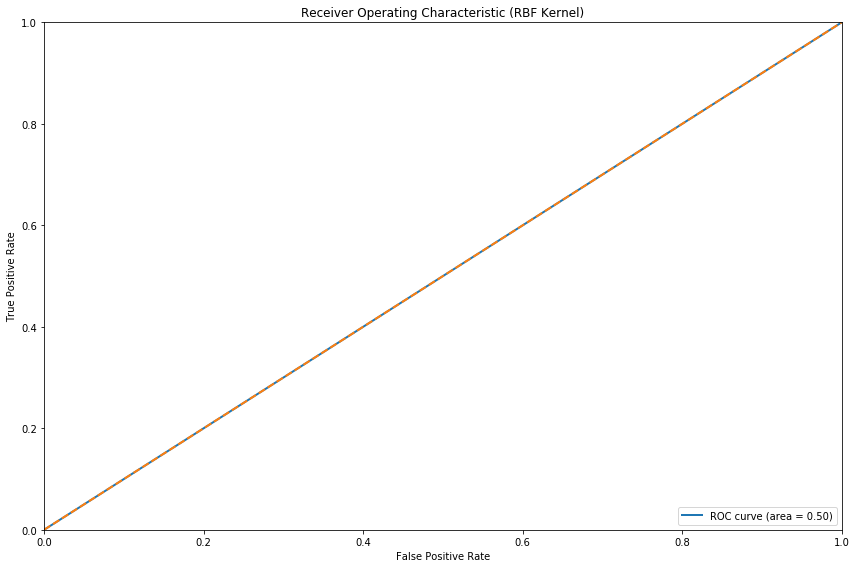

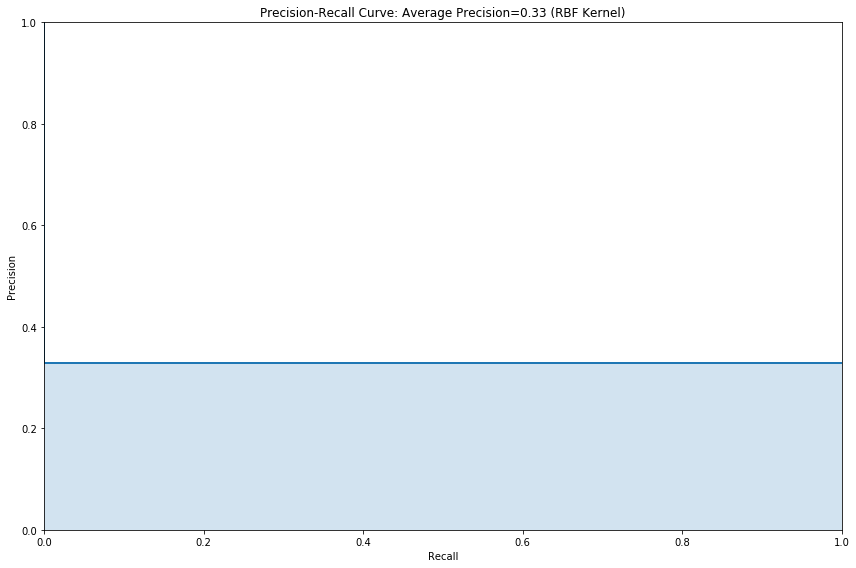

In [22]:
classifier_baseline_false = get_baseline_classifier(df_train_X, df_train_y, False)
print_classifier_results(classifier_baseline_false, df_eval_X, df_eval_y)

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Results for baseline classifier:


Overall F1 score: 0.49382716049382713
True positives: 20
True negatives: 0
False positives: 41
False negatives: 0


             precision    recall  f1-score   support

      False       0.00      0.00      0.00        41
       True       0.33      1.00      0.49        20

avg / total       0.11      0.33      0.16        61



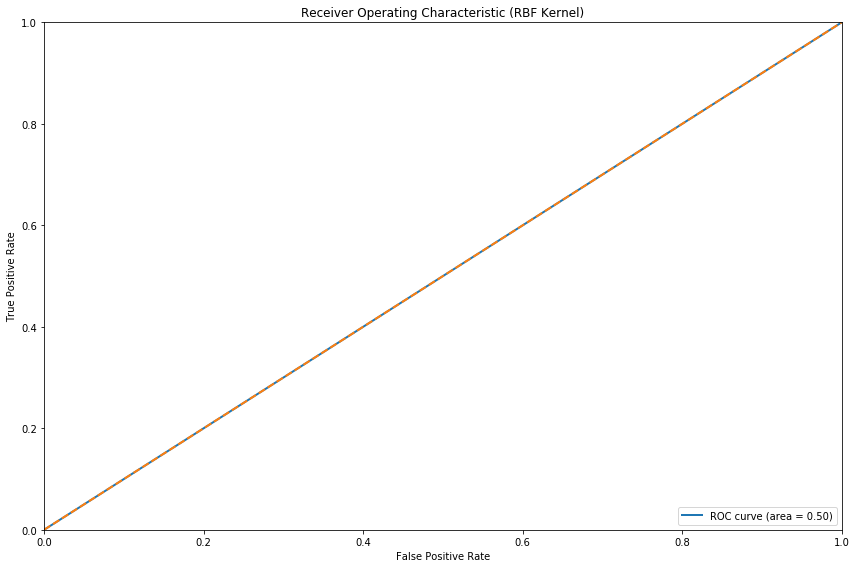

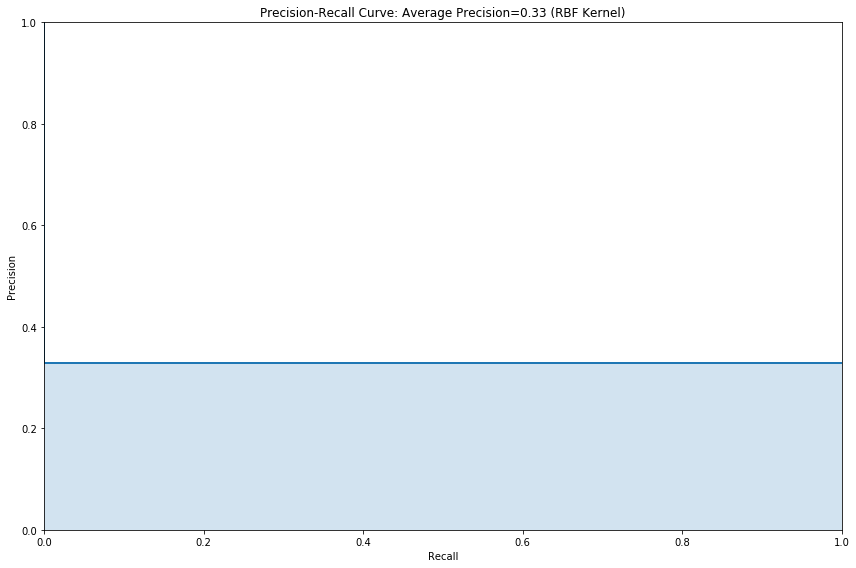

In [23]:
classifier_baseline_true = get_baseline_classifier(df_train_X, df_train_y, True)
print_classifier_results(classifier_baseline_true, df_eval_X, df_eval_y)

## Build SVC classifier (RBF Kernel)

Now, we build an SVM classifier and trial various parameters:

- Kernel: RBF, sigmoid, polynomial, linear

for the $C \in [0.01, 100000]$ term in the model (the error penalization term). This model uses a radial basis function (RBF) kernel.

Fitting 10 folds for each of 386 candidates, totalling 3860 fits
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.011048543456, kernel=rbf .....................
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.011048543456, kernel=sigmoid .................
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=rbf ...................
[CV] C=0.03125, gamma=0.011048543456, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.011048543456, kernel=rbf .....................
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.011048543456, kernel=sigmoid .................
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.011048543456, kernel=sigmoid .................
[CV] C=0.03125, gamma=0.011048543456, kernel=rbf .....................
[CV]  C=0.03125, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0392s.) Setting batch_size=10.
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.1s
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV] C=0.03125, gamma=0.011048543456, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=0.011048543456, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=4.0, kernel=rbf ................................
[CV]  C=0.03125, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.011048543456, kernel=rbf .....................
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV]  C=0.03125, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.011048543456, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV] C=0.03125, gamma=0.011048543456, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.011048543456, kernel=rbf .....................
[CV]  C=0.03125, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.011048543456, kernel=sigmoid .................
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV]  C=0.03125, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.011048543456, kernel=sigmoid .................
[CV] C=0.03125, gamma=0.011048543456, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................
[CV]  C=0.03125, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.011048543456, kernel=rbf .....................
[CV] C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid ...............
[CV] C=0.03125, gamma=0.011048543456, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.011048543456, kernel=rbf .....................
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=0.011048543456, kernel=sigmoid .................
[CV]  C=0.03125, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=1448.15468787, kernel=rbf ......................
[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................
[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1448.15468787, kernel=rbf ......................
[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=1448.15468787, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1448.15468787, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................
[CV] C=0.03125, gamma=4.0, kernel=rbf ................................
[CV]  C=0.03125, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1448.15468787, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.2, total=   0.0s
[CV]  C=0.03125, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1448.15468787, kernel=sigmoid ..................
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.2, total=   0.0s
[CV] ... C=0.03125, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=1448.15468787, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=1448.15468787, kernel=sigmoid ..................
[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1448.15468787, kernel=rbf ......................
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    0.5s
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1448.15468787, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=1448.15468787, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1448.15468787, kernel=sigmoid ..................
[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=524288.0, kernel=rbf ...........................
[CV]  C=0.03125, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1448.15468787, kernel=rbf ......................
[CV] C=0.03125, gamma=1448.15468787, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=524288.0, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1448.15468787, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=524288.0, kernel=rbf ...........................
[CV]  C=0.03125, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1448.15468787, kernel=rbf ......................
[CV] C=0.03125, gamma=1448.15468787, kernel=sigmoid ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1448.15468787, kernel=sigmoid ..................
[CV]  C=0.03125, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=524288.0, kernel=rbf ...........................
[CV] C=0.03125, gamma=1448.15468787, kernel=rbf ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=4.0, kernel=sigmoid ............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=524288.0, kernel=rbf ...........................
[CV] C=0.03125, gamma=524288.0, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=1448.15468787, kernel=rbf ......................
[CV]  C=0.03125, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=524288.0, kernel=sigmoid .......................
[CV] C=0.03125, gamma=524288.0, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=524288.0, kernel=rbf ...........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=524288.0, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf .............
[CV]  C=0.03125, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=524288.0, kernel=rbf ...........................
[CV]  C=0.03125, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf .............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=524288.0, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf .............
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf .............
[CV]  C=0.03125, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, gamma=524288.0, kernel=rbf ...........................
[CV]  C=0.03125, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=524288.0, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid .........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=524288.0, kernel=sigmoid, F1 Score=0.2, total=   0.0s
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf .............
[CV] C=0.03125, gamma=524288.0, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid .........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid .........
[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf .............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=524288.0, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid .........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid .........
[CV] C=0.03125, gamma=524288.0, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf .............
[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.82842712475, gamma=0.011048543456, kernel=rbf ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  78 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    0.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.03125, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid .........
[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf .............
[CV] C=0.03125, gamma=524288.0, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.82842712475, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid .........
[CV] C=2.82842712475, gamma=0.011048543456, kernel=rbf ...............
[CV]  C=0.03125, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, gamma=524288.0, kernel=sigmoid .......................
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf .............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid .........
[CV]  C=2.82842712475, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=0.011048543456, kernel=rbf ...............
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf .............
[CV] C=0.03125, gamma=524288.0, kernel=sigmoid .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=0.03125, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid .........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=0.011048543456, kernel=rbf ...............
[CV] C=2.82842712475, gamma=0.011048543456, kernel=sigmoid ...........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=0.011048543456, kernel=rbf ...............
[CV] C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid .........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.82842712475, gamma=0.011048543456, kernel=sigmoid ...........
[CV]  C=2.82842712475, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=0.011048543456, kernel=rbf ...............
[CV]  C=2.82842712475, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.82842712475, gamma=4.0, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=4.0, kernel=rbf ..........................
[CV]  C=2.82842712475, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=0.011048543456, kernel=rbf ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.82842712475, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=0.011048543456, kernel=sigmoid ...........
[CV] C=2.82842712475, gamma=4.0, kernel=rbf ..........................
[CV]  C=2.82842712475, gamma=4.0, kernel=rbf, F1 Score=0.15384615384615385, total=   0.0s
[CV] C=2.82842712475, gamma=4.0, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.82842712475, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.82842712475, gamma=0.011048543456, kernel=sigmoid ...........
[CV] C=2.82842712475, gamma=0.011048543456, kernel=rbf ...............
[CV]  C=2.82842712475, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=4.0, kernel=sigmoid ......................
[CV]  C=2.82842712475, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=0.011048543456, kernel=sigmoid ...........
[CV] C=2.82842712475, gamma=4.0, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.82842712475, gamma=0.011048543456, kernel=sigmoid ...........
[CV]  C=2.82842712475, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.82842712475, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=0.011048543456, kernel=rbf ...............
[CV] C=2.82842712475, gamma=4.0, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=4.0, kernel=rbf ..........................
[CV]  C=2.82842712475, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=0.011048543456, kernel=rbf ...............
[CV] C=2.82842712475, gamma=0.011048543456, kernel=sigmoid ...........
[CV]  C=2.82842712475, gamma=4.0, kernel=sigmoid, F1 Score=0.4761904761904762, total=   0.0s
[Parallel(n_jobs=4)]: Done  98 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 108 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 118 tasks      | elapsed:    1.1s
[CV] C=2.82842712475, gamma=4.0, kernel=sigmoid ......................
[CV]  C=2.82842712475, gamma=4.0, kernel=rbf, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=2.82842712475, gamma=4.0, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=2.82842712475, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=0.011048543456, kernel=sigmoid ...........
[CV] C=2.82842712475, gamma=4.0, kernel=sigmoid ......................
[CV]  C=2.82842712475, gamma=4.0, kernel=sigmoid, F1 Score=0.26666666666666666, total=   0.0s
[CV] C=2.82842712475, gamma=4.0, kernel=sigmoid ......................
[CV]  C=2.82842712475, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=4.0, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=4.0, kernel=sigmoid, F1 Score=0.33333333333333326, total=   0.0s
[CV]  C=2.82842712475, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=4.0, kernel=sigmoid ......................
[CV] C=2.82842712475, gamma=0.011048543456, kernel=sigmoid ...........
[CV]  C=2.82842712475, gamma=4.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=2.82842712475, gamma=4.0, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=4.0, kernel=rbf, F1 Score=0.26666666666666666, total=   0.0s
[CV] C=2.82842712475, gamma=4.0, kernel=rbf ..........................
[CV]  C=2.82842712475, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=0.011048543456, kernel=sigmoid ...........
[CV]  C=2.82842712475, gamma=4.0, kernel=sigmoid, F1 Score=0.35714285714285715, total=   0.0s
[CV] C=2.82842712475, gamma=1448.15468787, kernel=rbf ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.82842712475, gamma=4.0, kernel=sigmoid ......................
[CV]  C=2.82842712475, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.82842712475, gamma=1448.15468787, kernel=rbf ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.82842712475, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=1448.15468787, kernel=rbf ................
[CV] C=2.82842712475, gamma=4.0, kernel=rbf ..........................
[CV]  C=2.82842712475, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=4.0, kernel=sigmoid ......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=1448.15468787, kernel=rbf ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=4.0, kernel=sigmoid, F1 Score=0.3, total=   0.0s
[CV] C=2.82842712475, gamma=4.0, kernel=sigmoid ......................
[CV]  C=2.82842712475, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=1448.15468787, kernel=rbf ................
[CV]  C=2.82842712475, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=1448.15468787, kernel=sigmoid ............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.0s
[CV]  C=2.82842712475, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=1448.15468787, kernel=sigmoid ............
[CV]  C=2.82842712475, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.82842712475, gamma=4.0, kernel=sigmoid, F1 Score=0.11111111111111112, total=   0.0s
[CV] C=2.82842712475, gamma=1448.15468787, kernel=sigmoid ............
[CV] C=2.82842712475, gamma=1448.15468787, kernel=rbf ................
[CV] C=2.82842712475, gamma=524288.0, kernel=rbf .....................
[CV]  C=2.82842712475, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 138 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 148 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 158 tasks      | elapsed:    1.5s
[CV]  C=2.82842712

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.4761904761904762, total=   0.0s
[CV]  C=2.82842712475, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=1448.15468787, kernel=sigmoid ............
[CV] C=2.82842712475, gamma=524288.0, kernel=rbf .....................
[CV]  C=2.82842712475, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=1448.15468787, kernel=rbf ................
[CV]  C=2.82842712475, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.25, total=   0.0s
[CV] C=2.82842712475, gamma=1448.15468787, kernel=sigmoid ............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV]  C=2.82842712475, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.82842712475, gamma=524288.0, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=1448.15468787, kernel=sigmoid ............
[CV]  C=2.82842712475, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=1448.15468787, kernel=rbf ................
[CV] C=2.82842712475, gamma=524288.0, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=1448.15468787, kernel=sigmoid ............
[CV]  C=2.82842712475, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=524288.0, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.33333333333333326, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.82842712475, gamma=1448.15468787, kernel=sigmoid ............
[CV]  C=2.82842712475, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.82842712475, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=1448.15468787, kernel=rbf ................
[CV] C=2.82842712475, gamma=524288.0, kernel=rbf .....................
[CV]  C=2.82842712475, gamma=524288.0, kernel=sigmoid, F1 Score=0.4761904761904762, total=   0.0s
[CV]  C=2.82842712475, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=2.82842712475, gamma=1448.15468787, kernel=sigmoid ............
[CV] C=2.82842712475, gamma=524288.0, kernel=sigmoid .................
[CV]  C=2.82842712475, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.10526315789473685, total=   0.0s
[CV] C=2.82842712475, gamma=524288.0, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=524288.0, kernel=sigmoid, F1 Score=0.25, total=   0.0s
[CV]  C=2.82842712475, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2.82842712475, gamma=524288.0, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.0s
[CV] C=2.82842712475, gamma=524288.0, kernel=rbf .....................
[CV]  C=2.82842712475, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=524288.0, kernel=sigmoid .................
[CV] C=2.82842712475, gamma=1448.15468787, kernel=rbf ................
[CV]  C=2.82842712475, gamma=524288.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=2.82842712475, gamma=524288.0, kernel=sigmoid .................
[CV] C=2.82842712475, gamma=524288.0, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=524288.0, kernel=sigmoid, F1 Score=0.3448275862068965, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV]  C=2.82842712475, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=524288.0, kernel=rbf .....................
[CV] C=2.82842712475, gamma=524288.0, kernel=sigmoid .................
[CV]  C=2.82842712475, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV]  C=2.82842712475, gamma=524288.0, kernel=sigmoid, F1 Score=0.33333333333333326, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.82842712475, gamma=524288.0, kernel=sigmoid .................
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV]  C=2.82842712475, gamma=524288.0, kernel=sigmoid, F1 Score=0.3157894736842105, total=   0.0s
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.82842712475, gamma=524288.0, kernel=sigmoid .................
[CV]  C=2.82842712475, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV] C=2.82842712475, gamma=524288.0, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=524288.0, kernel=sigmoid, F1 Score=0.10526315789473685, total=   0.0s
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=2.82842712475, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2.82842712475, gamma=524288.0, kernel=rbf .....................
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 168 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 178 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 188 tasks      | elapsed:    1.8s
[CV] C=2.82842712475, gamma=524288.0, kernel=rbf .....................
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................
[CV] C=256.0, gamma=0.011048543456, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2.82842712475, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.011048543456, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=256.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.011048543456, kernel=rbf .......................
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=0.011048543456, kernel=rbf .......................
[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV]  C=256.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.011048543456, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.011048543456, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV]  C=256.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................
[CV] C=256.0, gamma=0.011048543456, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=3.0517578125e-05, kernel=sigmoid .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.011048543456, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................
[Parallel(n_jobs=4)]: Done 198 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 208 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 218 tasks      | elapsed:    2.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.011048543456, kernel=rbf .......................
[CV] ..... C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.011048543456, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................
[CV] . C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=0.011048543456, kernel=rbf .......................
[CV]  C=256.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=256.0, gamma=0.011048543456, kernel=sigmoid ...................
[CV]  C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.4761904761904762, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.26666666666666666, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................
[CV] C=256.0, gamma=0.011048543456, kernel=rbf .......................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV]  C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................
[CV] C=256.0, gamma=0.011048543456, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................
[CV] . C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................
[CV]  C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.3157894736842105, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................
[CV]  C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.2105263157894737, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=sigmoid ..............................
[CV]  C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.37037037037037035, total=   0.0s
[CV]  C=256.0, gamma=4.0, kernel=sigmoid, F1 Score=0.11111111111111112, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=rbf ........................
[CV] C=256.0, gamma=1448.15468787, kernel=rbf ........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=256.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=rbf ........................
[CV] C=256.0, gamma=1448.15468787, kernel=rbf ........................
[CV]  C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.22222222222222224, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=256.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=rbf ........................
[CV] C=256.0, gamma=1448.15468787, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=256.0, gamma=0.011048543456, kernel=sigmoid ...................
[CV]  C=256.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=sigmoid ....................
[Parallel(n_jobs=4)]: Done 228 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 238 tasks      | elapsed:    2.5s
[CV]  C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.15384615384615385, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.4761904761904762, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=sigmoid ....................
[CV]  C=256.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=rbf ........................
[CV]  C=256.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.26666666666666666, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=sigmoid ....................
[CV]  C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.3076923076923077, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................
[CV]  C=256.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=sigmoid ....................
[CV]  C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.42857142857142855, total=   0.0s
[CV]  C=256.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................
[CV] C=256.0, gamma=1448.15468787, kernel=rbf ........................
[CV]  C=256.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.33333333333333326, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=sigmoid ....................
[CV]  C=256.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=256.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=rbf ........................
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................
[CV]  C=256.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.10526315789473685, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=sigmoid ....................
[CV]  C=256.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=sigmoid ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=rbf ........................
[CV]  C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.26666666666666666, total=   0.0s
[CV]  C=256.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.35714285714285715, total=   0.0s
[CV] C=256.0, gamma=524288.0, kernel=rbf .............................
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.2s
[CV] C=256.0, gamma=0.011048543456, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=256.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=1448.15468787, kernel=rbf ........................
[CV] C=256.0, gamma=524288.0, kernel=rbf .............................
[CV] ..... C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=4.0, kernel=rbf ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=524288.0, kernel=rbf .............................
[CV]  C=256.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, gamma=524288.0, kernel=rbf .............................
[CV] ..... C=256.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=524288.0, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=256.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.0s
[CV] C=256.0, gamma=524288.0, kernel=rbf .............................
[CV] C=256.0, gamma=524288.0, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 248 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 258 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 268 tasks      | elapsed:    2.9s
[CV]  C=256.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.3448275862068965, total=   0.0s
[CV]  C=256.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf .............
[CV] C=256.0, gamma=524288.0, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=524288.0, kernel=sigmoid .........................
[CV] C=256.0, gamma=524288.0, kernel=rbf .............................
[CV]  C=256.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=524288.0, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.4761904761904762, total=   0.0s
[CV] C=256.0, gamma=524288.0, kernel=sigmoid .........................
[CV]  C=256.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=524288.0, kernel=rbf .............................
[CV]  C=256.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.26666666666666666, total=   0.0s
[CV] C=256.0, gamma=524288.0, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=256.0, gamma=524288.0, kernel=sigmoid .........................
[CV]  C=256.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=256.0, gamma=0.011048543456, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=524288.0, kernel=sigmoid .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=256.0, gamma=524288.0, kernel=rbf .............................
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf .............
[CV]  C=256.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.33333333333333326, total=   0.0s
[CV] C=256.0, gamma=524288.0, kernel=sigmoid .........................
[CV]  C=256.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.2105263157894737, total=   0.0s
[CV] C=256.0, gamma=524288.0, kernel=sigmoid .........................
[CV]  C=256.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.10526315789473685, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf .............
[CV]  C=256.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=524288.0, kernel=rbf .............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid .........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid .........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf .............
[CV] C=23170.4750059, gamma=0.011048543456, kernel=rbf ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf .............
[Parallel(n_jobs=4)]: Done 278 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 288 tasks      | elapsed:    3.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=256.0, gamma=0.011048543456, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf .............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid .........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid .........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid .........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid .........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid .........
[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf .............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid .........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid .........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.3s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=256.0, gamma=0.011048543456, kernel=sigmoid ...................
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid .........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=rbf ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf .............
[Parallel(n_jobs=4)]: Done 298 tasks      | elapsed:    3.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf .............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=256.0, gamma=0.011048543456, kernel=sigmoid ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf .............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=256.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.3s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=sigmoid ...........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.2s
[CV] C=23170.4750059, gamma=4.0, kernel=rbf ..........................
[CV]  C=23170.4750059, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=4.0, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=4.0, kernel=sigmoid ......................
[CV]  C=23170.4750059, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=4.0, kernel=sigmoid ......................
[CV]  C=23170.4750059, gamma=0.011048543456, kernel=rbf, F1 Score=0.26086956521739135, total=   1.1s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=rbf ...............
[Parallel(n_jobs=4)]: Done 308 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 318 tasks      | elapsed:    4.3s
[CV]  C=23170.4750059, gamma=4.0, kernel=sigmoid, F1 Score=0.4761904761904762, total=   0.0s
[CV] C=23170.4750059, gamma=4.0, kernel=sigmoid ......................
[CV]  C=23170.4750059, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=4.0, kernel=sigmoid ......................
[CV]  C=23170.4750059, gamma=4.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=4.0, kernel=sigmoid ......................
[CV]  C=23170.4750059, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=4.0, kernel=sigmoid ......................
[CV]  C=23170.4750059, gamma=4.0, kernel=sigmoid, F1 Score=0.2105263157894737, total=   0.0s
[CV] C=23170.4750059, gamma=4.0, kernel=sigmoid ......................
[CV]  C=23170.4750059, gamma=4.0, kernel=sigmoid, F1 Score=0.11111111111111112, total=   0.0s
[CV] C=23170.4750059, gamma=4.0, kernel=sigmoid ......................
[CV]  C=23170.4750059, gamma=4.0, kernel=sigmoid, F1 Score=0.3157894736842105, total=   0.0s
[CV] C=23170.4750059, gamma=4.0, kernel=sigmoid ......................
[CV]  C=23170.4750059, gamma=4.0, kernel=sigmoid, F1 Score=0.37037037037037035, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=rbf ................
[CV]  C=23170.4750059, gamma=0.011048543456,

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=rbf ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=23170.4750059, gamma=0.011048543456, kernel=rbf, F1 Score=0.2, total=   1.1s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=rbf ...............
[CV] C=23170.4750059, gamma=1448.15468787, kernel=rbf ................
[Parallel(n_jobs=4)]: Done 328 tasks      | elapsed:    4.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=rbf ................
[CV]  C=23170.4750059, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=rbf ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=rbf ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=rbf ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=rbf ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=rbf ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=rbf ................
[CV]  C=23170.4750059, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.2105263157894737, total=   0.5s
[CV] C=23170.4750059, gamma=4.0, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=sigmoid ............
[CV]  C=23170.4750059, gamma=4.0, kernel=rbf, F1 Score=0.22222222222222224, total=   0.0s
[CV] C=23170.4750059, gamma=4.0, kernel=rbf ..........................
[CV]  C=23170.4750059, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=sigmoid ............
[CV]  C=23170.4750059, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.4761904761904762, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=sigmoid ............
[CV]  C=23170.4750059, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.26666666666666666, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=sigmoid ............
[CV]  C=23170.4750059, gamma=4.0, kernel=rbf, F1 Score=0.15384615384615385, total=   0.0s
[CV]  C=23170.4750059, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.222222222222222

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=sigmoid ............
[Parallel(n_jobs=4)]: Done 338 tasks      | elapsed:    5.2s
[CV]  C=23170.4750059, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.33333333333333326, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=sigmoid ............
[CV]  C=23170.4750059, gamma=4.0, kernel=rbf, F1 Score=0.3076923076923077, total=   0.0s
[CV] C=23170.4750059, gamma=4.0, kernel=rbf ..........................
[CV]  C=23170.4750059, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=sigmoid ............
[CV]  C=23170.4750059, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.10526315789473685, total=   0.0s
[CV] C=23170.4750059, gamma=1448.15468787, kernel=sigmoid ............
[CV]  C=23170.4750059, gamma=4.0, kernel=rbf, F1 Score=0.42857142857142855, total=   0.0s
[CV] C=23170.4750059,

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=524288.0, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=23170.4750059, gamma=4.0, kernel=rbf, F1 Score=0.28571428571428575, total=   0.0s
[CV] C=23170.4750059, gamma=524288.0, kernel=rbf .....................
[CV] C=23170.4750059, gamma=4.0, kernel=rbf ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=23170.4750059, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=4.0, kernel=rbf ..........................
[CV] C=23170.4750059, gamma=524288.0, kernel=rbf .....................
[Parallel(n_jobs=4)]: Done 348 tasks      | elapsed:    5.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=524288.0, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=524288.0, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=23170.4750059, gamma=524288.0, kernel=rbf .....................
[CV]  C=23170.4750059, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=524288.0, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=524288.0, kernel=sigmoid .................
[CV]  C=23170.4750059, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=524288.0, kernel=rbf .....................
[CV]  C=23170.4750059, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=524288.0, kernel=sigmoid .................
[CV]  C=23170.4750059, gamma=524288.0, kernel=sigmoid, F1 Score=0.4761904761904762, total=   0.0s
[CV] C=23170.4750059, gamma=524288.0, kernel=sigmoid .................
[CV]  C=23170.4750059, gamma=524288.0, kernel=sigmoid, F1 Score=0.25, total=   0.0s
[CV]  C=23170.4750059, gamma=0.011048543456, kernel=rbf, F1 Score=0.25, total=   1.4s
[CV] C=23170.4750059, gamma=524288.0, kernel=sigmoid .................
[CV] C=23170.4750059, gamma=0.011048543456, kernel=rbf ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=524288.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=23170.4750059, gamma=524288.0, kernel=sigmoid .................
[CV]  C=23170.4750059, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.1s
[CV] C=23170.4750059, gamma=524288.0, kernel=rbf .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=524288.0, kernel=sigmoid .................
[CV]  C=23170.4750059, gamma=524288.0, kernel=sigmoid, F1 Score=0.33333333333333326, total=   0.0s
[CV] C=23170.4750059, gamma=524288.0, kernel=sigmoid .................
[Parallel(n_jobs=4)]: Done 358 tasks      | elapsed:    5.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=23170.4750059, gamma=524288.0, kernel=sigmoid .................
[CV]  C=23170.4750059, gamma=524288.0, kernel=sigmoid, F1 Score=0.3157894736842105, total=   0.0s
[CV] C=23170.4750059, gamma=524288.0, kernel=sigmoid .................
[CV]  C=23170.4750059, gamma=524288.0, kernel=sigmoid, F1 Score=0.23529411764705882, total=   0.0s
[CV] C=23170.4750059, gamma=524288.0, kernel=sigmoid .................
[CV]  C=23170.4750059, gamma=524288.0, kernel=sigmoid, F1 Score=0.10526315789473685, total=   0.0s
[CV]  C=23170.4750059, gamma=524288.0, kernel=sigmoid, F1 Score=0.3448275862068965, total=   0.0s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=rbf .................
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=rbf .................
[Parallel(n_jobs=4)]: Done 368 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 378 tasks      | elapsed:    5.9s
[CV]  C=23170.4750059, gamma=0.011048543456, kerne

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.4s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=rbf .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.5s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=rbf .................
[CV]  C=23170.4750059, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.10526315789473685, total=   0.5s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=sigmoid ...........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.5s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=rbf .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.4s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid .............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid .............
[CV]  C=23170.4750059, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.631578947368421, total=   0.4s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=sigmoid ...........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid .............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid .............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid .............
[CV]  C=23170.4750059, gamma=0.011048543456, kernel=rbf, F1 Score=0.16666666666666666, total=   1.4s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=rbf ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid .............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.4s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=rbf .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid .............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid .............
[CV]  C=23170.4750059, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.5s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=sigmoid ...........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid .............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid .............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=sigmoid, F1 Score=0.0, total=   0.1s
[CV] C=2097152.0, gamma=0.011048543456, kernel=rbf ...................
[Parallel(n_jobs=4)]: Done 388 tasks      | elapsed:    7.5s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.4s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=rbf .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.5s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=sigmoid ...........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.5s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=rbf .................
[CV]  C=23170.4750059, gamma=0.011048543456, kernel=rbf, F1 Score=0.5, total=   1.2s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=rbf ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.5s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=sigmoid ...........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.5s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=rbf .................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.5s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=sigmoid ...........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.6s
[CV] C=2097152.0, gamma=3.0517578125e-05, kernel=rbf .................
[CV]  C=23170.4750059, gamma=0.011048543456, kernel=rbf, F1 Score=0.18181818181818182, total=   0.9s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=rbf ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.5s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=sigmoid ...........


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=3.0517578125e-05, kernel=rbf, F1 Score=0.0, total=   0.6s
[CV] C=2097152.0, gamma=0.011048543456, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=23170.4750059, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.4s
[CV] C=2097152.0, gamma=0.011048543456, kernel=sigmoid ...............
[Parallel(n_jobs=4)]: Done 398 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Batch computation too slow (2.5411s.) Setting batch_size=5.
[Parallel(n_jobs=4)]: Done 408 tasks      | elapsed:   10.0s
[CV]  C=23170.4750059, gamma=0.011048543456, kernel=rbf, F1 Score=0.39999999999999997, total=   1.0s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=rbf ...............
[CV]  C=2097152.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.13333333333333333, total=   0.7s
[CV] C=2097152.0, gamma=0.011048543456, kernel=sigmoid ...............
[CV]  C=2097152.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.4, total=   0.7s
[CV] C=2097152.0, gamma=4.0, kernel=rbf ..............................
[CV]  C=23170.4750059, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=   1.1s
[CV] C=23170.4750059, gamma=0.011048543456, kernel=

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=2097152.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=4.0, kernel=rbf ..............................
[CV] . C=2097152.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=4.0, kernel=rbf ..............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=2097152.0, gamma=4.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=4.0, kernel=sigmoid ..........................
[CV]  C=2097152.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=4.0, kernel=sigmoid ..........................
[CV]  C=2097152.0, gamma=4.0, kernel=sigmoid, F1 Score=0.4761904761904762, total=   0.0s
[CV] C=2097152.0, gamma=4.0, kernel=sigmoid ..........................
[Parallel(n_jobs=4)]: Done 418 tasks      | elapsed:   11.7s
[CV]  C=2097152.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=4.0, kernel=sigmoid ..........................
[CV]  C=2097152.0, gamma=4.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=2097152.0, gamma=4.0, kernel=sigmoid ..........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=4.0, kernel=sigmoid ..........................
[CV]  C=2097152.0, gamma=4.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=4.0, kernel=sigmoid ..........................
[CV]  C=2097152.0, gamma=4.0, kernel=sigmoid, F1 Score=0.2105263157894737, total=   0.0s
[CV] C=2097152.0, gamma=4.0, kernel=sigmoid ..........................
[CV]  C=2097152.0, gamma=4.0, kernel=sigmoid, F1 Score=0.11111111111111112, total=   0.0s
[CV] C=2097152.0, gamma=4.0, kernel=sigmoid ..........................
[CV]  C=2097152.0, gamma=4.0, kernel=sigmoid, F1 Score=0.3157894736842105, total=   0.0s
[CV] C=2097152.0, gamma=4.0, kernel=sigmoid ..........................
[CV]  C=2097152.0, gamma=4.0, kernel=sigmoid, F1 Score=0.37037037037037035, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=rbf ....................
[Parallel(n_jobs=4)]: Done 428 tasks      | elapsed:   12.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=rbf ....................
[CV]  C=2097152.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=rbf ....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=23170.4750059, gamma=0.011048543456, kernel=rbf, F1 Score=0.2, total=   1.3s
[CV] C=2097152.0, gamma=1448.15468787, kernel=rbf ....................
[CV] C=2097152.0, gamma=1448.15468787, kernel=sigmoid ................
[CV]  C=2097152.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=sigmoid ................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=1448.15468787, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=sigmoid ................
[CV]  C=2097152.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=sigmoid ................
[CV]  C=2097152.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=sigmoid ................
[CV]  C=2097152.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.33333333333333326, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=sigmoid ................
[CV]  C=2097152.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.4761904761904762, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=sigmoid ................
[CV]  C=2097152.0, gamma=1448.15468787, kernel=sigmoid, F1 Score=0.4, total=   0.0s
[CV] C=2097152.0, gamma=1448.15468787, kernel=sigmoid ................
[CV]  C=2097152.0, gamma=1448.15468787, ker

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2097152.0, gamma=524288.0, kernel=rbf .........................
[CV]  C=2097152.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=524288.0, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=524288.0, kernel=rbf .........................
[CV]  C=2097152.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=524288.0, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV]  C=2097152.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=524288.0, kernel=rbf .........................
[CV] C=2097152.0, gamma=524288.0, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2097152.0, gamma=524288.0, kernel=rbf .........................
[CV]  C=2097152.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=524288.0, kernel=rbf .........................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=524288.0, kernel=rbf .........................
[CV]  C=2097152.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=524288.0, kernel=sigmoid .....................
[CV]  C=2097152.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=2097152.0, gamma=524288.0, kernel=sigmoid .....................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=524288.0, kernel=rbf, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2097152.0, gamma=524288.0, kernel=sigmoid .....................
[CV]  C=2097152.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=524288.0, kernel=sigmoid .....................
[CV]  C=2097152.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=524288.0, kernel=sigmoid .....................
[CV]  C=2097152.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.33333333333333326, total=   0.0s
[CV]  C=2097152.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.4761904761904762, total=   0.0s
[CV] C=2097152.0, gamma=524288.0, kernel=sigmoid .....................
[CV] C=2097152.0, gamma=524288.0, kernel=sigmoid .....................
[CV]  C=2097152.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.22222222222222224, total=   0.0s
[CV]  C=2097152.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.26666666666666666, total=   0.0s
[CV] C=2097152.0, gamma=524288.0, kernel=sigmoid .....................
[CV] C=2097152.0, gamma=524288.0, ker

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=2, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 463 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 468 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 473 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 478 tasks      | elapsed:   13.1s
[CV]  C=2097152.0, gamma=524288.0, kernel=sigmoid, F1 Score=0.3448275862068965, total=   0.0s
[CV] C=0.03125, degree=2, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=2, kernel=poly ................................
[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=2, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=2, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=2, kernel=poly ................................
[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=2, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=2, kernel=poly ................................
[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=2, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=3, kernel=poly ................................
[CV] ... C=0.03125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=3, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=3, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=3, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=3, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=3, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=3, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 480 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 482 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 484 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 486 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 488 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 490 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 492 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 494 tasks      | elapsed:   13.4s
[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=3, kernel=poly ................................
[CV] C=0.03125, degree=3, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=3, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=4, kernel=poly ................................
[CV] ... C=0.03125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=4, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=4, kernel=poly ................................
[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=4, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=4, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=4, kernel=poly ................................
[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=4, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=4, kernel=poly ................................
[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=4, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=5, kernel=poly ................................
[CV] C=0.03125, degree=4, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=5, kernel=poly ................................
[CV] C=0.03125, degree=5, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 496 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 498 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1999s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done 500 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 502 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 506 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 508 tasks      | elapsed:   13.5s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=5, kernel=poly ................................
[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=5, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=5, kernel=poly ................................
[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=5, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=5, kernel=poly ................................
[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=6, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=5, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=6, kernel=poly ................................
[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=5, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=6, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=6, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=6, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=6, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=6, kernel=poly ................................
[CV] C=0.03125, degree=6, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=6, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=6, kernel=poly ................................
[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=7, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=7, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 512 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1923s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done 516 tasks      | elapsed:   13.7s
[Parallel(n_jobs=4)]: Done 520 tasks      | elapsed:   13.7s
[Parallel(n_jobs=4)]: Done 524 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done 528 tasks      | elapsed:   13.8s
[CV] C=0.03125, degree=7, kernel=poly ................................
[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=8, kernel=poly ................................
[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=7, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=8, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=8, kernel=poly ................................
[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=7, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=8, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=7, kernel=poly ................................
[CV] C=0.03125, degree=8, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=7, kernel=poly ................................
[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=8, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=8, kernel=poly ................................
[CV] C=0.03125, degree=7, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=7, kernel=poly ................................
[CV] C=0.03125, degree=8, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=7, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=8, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 532 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done 540 tasks      | elapsed:   14.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=9, kernel=poly ................................
[CV] C=0.03125, degree=8, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=9, kernel=poly ................................
[CV] C=0.03125, degree=9, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=9, kernel=poly ................................
[CV] C=0.03125, degree=9, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=9, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=9, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=10, kernel=poly ...............................
[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=9, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=9, kernel=poly ................................
[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=9, kernel=poly ................................
[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.03125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 548 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done 556 tasks      | elapsed:   14.2s
[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=10, kernel=poly ...............................
[CV] C=0.03125, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=11, kernel=poly ...............................
[CV] C=0.03125, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=10, kernel=poly ...............................
[CV] C=0.03125, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=11, kernel=poly ...............................
[CV] C=0.03125, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=11, kernel=poly ...............................
[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=11, kernel=poly ...............................
[CV] C=0.03125, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=11, kernel=poly ...............................
[CV] C=0.03125, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 564 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 572 tasks      | elapsed:   14.4s
[CV] .. C=0.03125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=12, kernel=poly ...............................
[CV] C=0.03125, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=12, kernel=poly ...............................
[CV] C=0.03125, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=12, kernel=poly ...............................
[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=12, kernel=poly ...............................
[CV] C=0.03125, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=13, kernel=poly ...............................
[CV] C=0.03125, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=13, kernel=poly ...............................
[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=13, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 580 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done 588 tasks      | elapsed:   14.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=14, kernel=poly ...............................
[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=14, kernel=poly ...............................
[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=14, kernel=poly ...............................
[CV] C=0.03125, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=14, kernel=poly ...............................
[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=14, kernel=poly ...............................
[CV] C=0.03125, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=15, kernel=poly ...............................
[CV] C=0.03125, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=15, kernel=poly ...............................
[CV] C=0.03125, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=15, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 596 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done 604 tasks      | elapsed:   14.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.03125, degree=15, kernel=poly ...............................
[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=16, kernel=poly ...............................
[CV] C=0.03125, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=16, kernel=poly ...............................
[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.03125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=2, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 612 tasks      | elapsed:   15.0s
[Parallel(n_jobs=4)]: Done 620 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 628 tasks      | elapsed:   15.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=2, kernel=poly .................................
[CV] C=0.0625, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=3, kernel=poly .................................
[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=3, kernel=poly .................................
[CV] C=0.0625, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=3, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=3, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=3, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=3, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=4, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=3, kernel=poly .................................
[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=4, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=4, kernel=poly .................................
[CV] C=0.0625, degree=3, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=3, kernel=poly .................................
[CV] C=0.0625, degree=4, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=3, kernel=poly .................................
[CV] C=0.0625, degree=4, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=4, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=4, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=4, kernel=poly .................................
[CV] C=0.0625, degree=4, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 636 tasks      | elapsed:   15.3s
[Parallel(n_jobs=4)]: Done 644 tasks      | elapsed:   15.3s
[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=5, kernel=poly .................................
[CV] C=0.0625, degree=4, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=5, kernel=poly .................................
[CV] C=0.0625, degree=5, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=5, kernel=poly .................................
[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=5, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=5, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=5, kernel=poly .................................
[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=5, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=5, kernel=poly .................................
[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=5, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 652 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 660 tasks      | elapsed:   15.5s
[CV] .... C=0.0625, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=6, kernel=poly .................................
[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=7, kernel=poly .................................
[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=6, kernel=poly .................................
[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=6, kernel=poly .................................
[CV] C=0.0625, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=7, kernel=poly .................................
[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=7, kernel=poly .................................
[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 668 tasks      | elapsed:   15.7s
[Parallel(n_jobs=4)]: Done 676 tasks      | elapsed:   15.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=8, kernel=poly .................................
[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=9, kernel=poly .................................
[CV] C=0.0625, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=8, kernel=poly .................................
[CV] C=0.0625, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=9, kernel=poly .................................
[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=9, kernel=poly .................................
[CV] C=0.0625, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=9, kernel=poly .................................
[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=9, kernel=poly .................................
[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=9, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 684 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 692 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done 700 tasks      | elapsed:   16.1s
[CV] .... C=0.0625, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=10, kernel=poly ................................
[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.0625, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=10, kernel=poly ................................
[CV] C=0.0625, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=10, kernel=poly ................................
[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=10, kernel=poly ................................
[CV] C=0.0625, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=10, kernel=poly ................................
[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 708 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done 716 tasks      | elapsed:   16.4s
[CV] C=0.0625, degree=12, kernel=poly ................................
[CV] C=0.0625, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=11, kernel=poly ................................
[CV] C=0.0625, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=12, kernel=poly ................................
[CV] C=0.0625, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=11, kernel=poly ................................
[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=11, kernel=poly ................................
[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=13, kernel=poly ................................
[CV] C=0.0625, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=13, kernel=poly ................................
[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=14, kernel=poly ................................
[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=13, kernel=poly ................................
[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=14, kernel=poly ................................
[CV] C=0.0625, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 724 tasks      | elapsed:   16.4s
[Parallel(n_jobs=4)]: Done 732 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 740 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 748 tasks      | elapsed:   16.7s
[CV] C=0.0625, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=15, kernel=poly ................................
[CV] C=0.0625, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=15, kernel=poly ................................
[CV] C=0.0625, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0625, degree=15, kernel=poly ................................
[CV] ... C=0.0625, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=15, kernel=poly ................................
[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=15, kernel=poly ................................
[CV] C=0.0625, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=15, kernel=poly ................................
[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 756 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done 764 tasks      | elapsed:   16.9s
[CV] C=0.0625, degree=15, kernel=poly ................................
[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.0625, degree=16, kernel=poly ................................
[CV] C=0.125, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0625, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=2, kernel=poly ..................................
[CV] C=0.125, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=2, kernel=poly ..................................
[CV] C=0.125, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................
[CV] C=0.125, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=2, kernel=poly ..................................
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 772 tasks      | elapsed:   17.1s
[Parallel(n_jobs=4)]: Done 780 tasks      | elapsed:   17.1s
[CV] ..... C=0.125, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=4, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=4, kernel=poly ..................................
[CV] C=0.125, degree=4, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=4, kernel=poly ..................................
[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=4, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=4, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=4, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=4, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=4, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=4, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 788 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Done 796 tasks      | elapsed:   17.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=5, kernel=poly ..................................
[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=5, kernel=poly ..................................
[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=6, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 804 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done 812 tasks      | elapsed:   17.6s
[Parallel(n_jobs=4)]: Done 820 tasks      | elapsed:   17.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=7, kernel=poly ..................................
[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=8, kernel=poly ..................................
[CV] ..... C=0.125, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=8, kernel=poly ..................................
[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 828 tasks      | elapsed:   17.8s
[Parallel(n_jobs=4)]: Done 836 tasks      | elapsed:   17.9s
[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=8, kernel=poly ..................................
[CV] C=0.125, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=8, kernel=poly ..................................
[CV] C=0.125, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=9, kernel=poly ..................................
[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=9, kernel=poly ..................................
[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=9, kernel=poly ..................................
[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=9, kernel=poly ..................................
[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=9, kernel=poly ..................................
[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=9, kernel=poly ..................................
[CV] C=0.125, degree=10, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 844 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done 852 tasks      | elapsed:   18.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=10, kernel=poly .................................
[CV] C=0.125, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=10, kernel=poly .................................
[CV] ..... C=0.125, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=10, kernel=poly .................................
[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=11, kernel=poly .................................
[CV] C=0.125, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=11, kernel=poly .................................
[CV] C=0.125, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 860 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done 868 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   18.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=12, kernel=poly .................................
[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=12, kernel=poly .................................
[CV] C=0.125, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=13, kernel=poly .................................
[CV] .... C=0.125, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=13, kernel=poly .................................
[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=13, kernel=poly .................................
[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................
[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 884 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done 892 tasks      | elapsed:   18.6s
[Parallel(n_jobs=4)]: Done 900 tasks      | elapsed:   18.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=14, kernel=poly .................................
[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................
[CV] C=0.125, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.125, degree=15, kernel=poly .................................
[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=15, kernel=poly .................................
[CV] C=0.125, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=16, kernel=poly .................................
[CV] .... C=0.125, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=16, kernel=poly .................................
[CV] C=0.125, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=16, kernel=poly .................................
[CV] C=0.125, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=16, kernel=poly .................................
[CV] C=0.125, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 908 tasks      | elapsed:   18.8s
[Parallel(n_jobs=4)]: Done 916 tasks      | elapsed:   18.9s
[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................
[CV] C=0.125, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.125, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.125, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 924 tasks      | elapsed:   19.0s
[Parallel(n_jobs=4)]: Done 932 tasks      | elapsed:   19.2s
[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=3, kernel=poly ...................................
[CV] C=0.25, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=4, kernel=poly ...................................
[CV] C=0.25, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=4, kernel=poly ...................................
[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=4, kernel=poly ...................................
[CV] C=0.25, degree=4, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 940 tasks      | elapsed:   19.2s
[Parallel(n_jobs=4)]: Done 948 tasks      | elapsed:   19.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=5, kernel=poly ...................................
[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=5, kernel=poly ...................................
[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=5, kernel=poly ...................................
[CV] C=0.25, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=5, kernel=poly ...................................
[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=5, kernel=poly ...................................
[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 956 tasks      | elapsed:   19.5s
[CV] ...... C=0.25, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=6, kernel=poly ...................................
[CV] C=0.25, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=6, kernel=poly ...................................
[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=7, kernel=poly ...................................
[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=7, kernel=poly ...................................
[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=6, kernel=poly ...................................
[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=7, kernel=poly ...................................
[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=7, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 964 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 972 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 980 tasks      | elapsed:   19.9s
[CV] C=0.25, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=8, kernel=poly ...................................
[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=8, kernel=poly ...................................
[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=8, kernel=poly ...................................
[CV] C=0.25, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=9, kernel=poly ...................................
[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 988 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 996 tasks      | elapsed:   20.1s
[CV] C=0.25, degree=9, kernel=poly ...................................
[CV] C=0.25, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=9, kernel=poly ...................................
[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=10, kernel=poly ..................................
[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=9, kernel=poly ...................................
[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.25, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=11, kernel=poly ..................................
[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1004 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done 1012 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 1020 tasks      | elapsed:   20.3s
[CV] C=0.25, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=11, kernel=poly ..................................
[CV] C=0.25, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=12, kernel=poly ..................................
[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=12, kernel=poly ..................................
[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=12, kernel=poly ..................................
[CV] ..... C=0.25, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................
[CV] C=0.25, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1028 tasks      | elapsed:   20.5s
[Parallel(n_jobs=4)]: Done 1036 tasks      | elapsed:   20.5s
[Parallel(n_jobs=4)]: Done 1044 tasks      | elapsed:   20.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=15, kernel=poly ..................................
[CV] C=0.25, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=15, kernel=poly ..................................
[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=14, kernel=poly ..................................
[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=14, kernel=poly ..................................
[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=14, kernel=poly ..................................
[CV] C=0.25, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=15, kernel=poly ..................................
[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=16, kernel=poly ..................................
[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=15, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 1052 tasks      | elapsed:   20.7s
[Parallel(n_jobs=4)]: Done 1060 tasks      | elapsed:   20.9s
[Parallel(n_jobs=4)]: Done 1068 tasks      | elapsed:   20.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, degree=16, kernel=poly ..................................
[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.25, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=0.25, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................
[CV] C=0.5, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................
[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 1076 tasks      | elapsed:   21.1s
[Parallel(n_jobs=4)]: Done 1084 tasks      | elapsed:   21.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=4, kernel=poly ....................................
[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=4, kernel=poly ....................................
[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................
[CV] C=0.5, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=5, kernel=poly ....................................
[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1092 tasks      | elapsed:   21.3s
[Parallel(n_jobs=4)]: Done 1100 tasks      | elapsed:   21.3s
[CV] ....... C=0.5, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=5, kernel=poly ....................................
[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=5, kernel=poly ....................................
[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................
[CV] C=0.5, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1108 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 1116 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 1124 tasks      | elapsed:   21.7s
[CV] C=0.5, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=7, kernel=poly ....................................
[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=7, kernel=poly ....................................
[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=7, kernel=poly ....................................
[CV] C=0.5, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=7, kernel=poly ....................................
[CV] C=0.5, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=8, kernel=poly ....................................
[CV] C=0.5, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=8, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 1132 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done 1140 tasks      | elapsed:   21.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=9, kernel=poly ....................................
[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=9, kernel=poly ....................................
[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=10, kernel=poly ...................................
[CV] C=0.5, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=0.5, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=10, kernel=poly ...................................
[CV] C=0.5, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=11, kernel=poly ...................................
[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1148 tasks      | elapsed:   22.0s
[Parallel(n_jobs=4)]: Done 1156 tasks      | elapsed:   22.1s
[Parallel(n_jobs=4)]: Done 1164 tasks      | elapsed:   22.2s
[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=11, kernel=poly ...................................
[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=12, kernel=poly ...................................
[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=13, kernel=poly ...................................
[CV] C=0.5, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=12, kernel=poly ...................................
[CV] C=0.5, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=12, kernel=poly ...................................
[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=13, kernel=poly ...................................
[CV] C=0.5, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=12, kernel=poly ...................................
[CV] C=0.5, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1172 tasks      | elapsed:   22.3s
[Parallel(n_jobs=4)]: Done 1180 tasks      | elapsed:   22.4s
[Parallel(n_jobs=4)]: Done 1188 tasks      | elapsed:   22.5s
[CV] ...... C=0.5, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=13, kernel=poly ...................................
[CV] C=0.5, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=14, kernel=poly ...................................
[CV] C=0.5, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=14, kernel=poly ...................................
[CV] ...... C=0.5, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=14, kernel=poly ...................................
[CV] C=0.5, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=15, kernel=poly ...................................
[CV] C=0.5, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1196 tasks      | elapsed:   22.6s
[Parallel(n_jobs=4)]: Done 1204 tasks      | elapsed:   22.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=16, kernel=poly ...................................
[CV] C=0.5, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=16, kernel=poly ...................................
[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=15, kernel=poly ...................................
[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=15, kernel=poly ...................................
[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=15, kernel=poly ...................................
[CV] C=0.5, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=16, kernel=poly ...................................
[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.5, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.5, degree=16, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 1212 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done 1220 tasks      | elapsed:   22.9s
[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=0.5, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=2, kernel=poly ....................................
[CV] C=1.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=2, kernel=poly ....................................
[CV] C=1.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=2, kernel=poly ....................................
[CV] C=1.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................
[CV] C=1.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 1228 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 1236 tasks      | elapsed:   23.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................
[CV] C=1.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=3, kernel=poly ....................................
[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1244 tasks      | elapsed:   23.2s
[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................
[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=6, kernel=poly ....................................
[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1252 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 1260 tasks      | elapsed:   23.5s
[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=7, kernel=poly ....................................
[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=7, kernel=poly ....................................
[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=7, kernel=poly ....................................
[CV] C=1.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=8, kernel=poly ....................................
[CV] ....... C=1.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1268 tasks      | elapsed:   23.7s
[Parallel(n_jobs=4)]: Done 1276 tasks      | elapsed:   23.7s
[CV] C=1.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=8, kernel=poly ....................................
[CV] C=1.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=8, kernel=poly ....................................
[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=8, kernel=poly ....................................
[CV] C=1.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=9, kernel=poly ....................................
[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1284 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done 1292 tasks      | elapsed:   24.0s
[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=9, kernel=poly ....................................
[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=1.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=10, kernel=poly ...................................
[CV] C=1.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=10, kernel=poly ...................................
[CV] C=1.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=11, kernel=poly ...................................
[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=11, kernel=poly ...................................
[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=10, kernel=poly ...................................
[CV] C=1.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=11, kernel=poly ...................................
[CV] ...... C=1.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1300 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 1308 tasks      | elapsed:   24.1s
[CV] C=1.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=12, kernel=poly ...................................
[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=12, kernel=poly ...................................
[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=12, kernel=poly ...................................
[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=12, kernel=poly ...................................
[CV] C=1.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=12, kernel=poly ...................................
[CV] C=1.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1316 tasks      | elapsed:   24.3s
[Parallel(n_jobs=4)]: Done 1324 tasks      | elapsed:   24.4s
[Parallel(n_jobs=4)]: Done 1332 tasks      | elapsed:   24.5s
[CV] ...... C=1.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=13, kernel=poly ...................................
[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=14, kernel=poly ...................................
[CV] C=1.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=13, kernel=poly ...................................
[CV] C=1.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=14, kernel=poly ...................................
[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=14, kernel=poly ...................................
[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=15, kernel=poly ...................................
[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1340 tasks      | elapsed:   24.5s
[Parallel(n_jobs=4)]: Done 1348 tasks      | elapsed:   24.7s
[Parallel(n_jobs=4)]: Done 1356 tasks      | elapsed:   24.7s
[CV] C=1.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=14, kernel=poly ...................................
[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=15, kernel=poly ...................................
[CV] C=1.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=15, kernel=poly ...................................
[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=15, kernel=poly ...................................
[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=15, kernel=poly ...................................
[CV]  C=2097152.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.0, total=  17.3s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2097152.0, gamma=0.011048543456, kernel=rbf ...................
[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=15, kernel=poly ...................................
[CV] C=1.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.0, degree=16, kernel=poly ...................................
[CV] ...... C=1.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=16, kernel=poly ...................................
[CV] C=2.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=16, kernel=poly ...................................
[CV] C=2.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=16, kernel=poly ...................................
[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=16, kernel=poly ...................................
[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1.0, degree=16, kernel=poly ...................................
[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=1.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=2, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 1364 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done 1372 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done 1380 tasks      | elapsed:   25.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=2, kernel=poly ....................................
[CV] C=2.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=3, kernel=poly ....................................
[CV] C=2.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=3, kernel=poly ....................................
[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=3, kernel=poly ....................................
[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1388 tasks      | elapsed:   25.2s
[Parallel(n_jobs=4)]: Done 1396 tasks      | elapsed:   25.4s
[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=4, kernel=poly ....................................
[CV] C=2.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=4, kernel=poly ....................................
[CV] C=2.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=4, kernel=poly ....................................
[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=6, kernel=poly ....................................
[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=5, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 1404 tasks      | elapsed:   25.5s
[Parallel(n_jobs=4)]: Done 1412 tasks      | elapsed:   25.6s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=6, kernel=poly ....................................
[CV] C=2.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=6, kernel=poly ....................................
[CV] C=2.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=7, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 1420 tasks      | elapsed:   25.7s
[Parallel(n_jobs=4)]: Done 1428 tasks      | elapsed:   25.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=7, kernel=poly ....................................
[CV] C=2.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=8, kernel=poly ....................................
[CV] C=2.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=8, kernel=poly ....................................
[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=9, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 1436 tasks      | elapsed:   26.0s
[Parallel(n_jobs=4)]: Done 1444 tasks      | elapsed:   26.1s
[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=9, kernel=poly ....................................
[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=9, kernel=poly ....................................
[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=10, kernel=poly ...................................
[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=2.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=10, kernel=poly ...................................
[CV] C=2.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=10, kernel=poly ...................................
[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=10, kernel=poly ...................................
[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=10, kernel=poly ...................................
[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=11, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 1452 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done 1460 tasks      | elapsed:   26.3s
[Parallel(n_jobs=4)]: Done 1468 tasks      | elapsed:   26.4s
[CV] C=2.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=11, kernel=poly ...................................
[CV] C=2.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=12, kernel=poly ...................................
[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=12, kernel=poly ...................................
[CV] C=2.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=12, kernel=poly ...................................
[CV] C=2.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=13, kernel=poly ...................................
[CV] C=2.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1476 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done 1484 tasks      | elapsed:   26.6s
[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................
[CV] C=2.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, degree=15, kernel=poly ...................................
[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1492 tasks      | elapsed:   26.7s
[Parallel(n_jobs=4)]: Done 1500 tasks      | elapsed:   26.7s
[Parallel(n_jobs=4)]: Done 1508 tasks      | elapsed:   26.9s
[Parallel(n_jobs=4)]: Done 1516 tasks      | elapsed:   26.9s
[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................
[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................
[CV] C=2.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=2.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................
[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1524 tasks      | elapsed:   27.1s
[Parallel(n_jobs=4)]: Done 1532 tasks      | elapsed:   27.1s
[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=4, kernel=poly ....................................
[CV] C=4.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=4, kernel=poly ....................................
[CV]  C=2097152.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.16666666666666666, total=  17.6s
[CV] C=2097152.0, gamma=0.011048543456, kernel=rbf ...................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1540 tasks      | elapsed:   27.3s
[Parallel(n_jobs=4)]: Done 1548 tasks      | elapsed:   27.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=4, kernel=poly ....................................
[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=5, kernel=poly ....................................
[CV] C=4.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=6, kernel=poly ....................................
[CV] C=4.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=6, kernel=poly ....................................
[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=6, kernel=poly ....................................
[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=6, kernel=poly ....................................
[CV] C=4.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=6, kernel=poly ....................................
[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=6, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 1556 tasks      | elapsed:   27.6s
[Parallel(n_jobs=4)]: Done 1564 tasks      | elapsed:   27.6s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=7, kernel=poly ....................................
[CV] C=4.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=7, kernel=poly ....................................
[CV] C=4.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=7, kernel=poly ....................................
[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=8, kernel=poly ....................................
[CV] C=4.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=8, kernel=poly ....................................
[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=8, kernel=poly ....................................
[CV] C=4.0, degree=7, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 1572 tasks      | elapsed:   27.8s
[Parallel(n_jobs=4)]: Done 1580 tasks      | elapsed:   27.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=8, kernel=poly ....................................
[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1588 tasks      | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done 1596 tasks      | elapsed:   28.1s
[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=4.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=11, kernel=poly ...................................
[CV] C=4.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=11, kernel=poly ...................................
[CV] C=4.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=11, kernel=poly ...................................
[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=11, kernel=poly ...................................
[CV] C=4.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=11, kernel=poly ...................................
[CV] ...... C=4.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1604 tasks      | elapsed:   28.3s
[Parallel(n_jobs=4)]: Done 1612 tasks      | elapsed:   28.3s
[Parallel(n_jobs=4)]: Done 1620 tasks      | elapsed:   28.5s
[CV] C=4.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=12, kernel=poly ...................................
[CV] C=4.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=12, kernel=poly ...................................
[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=12, kernel=poly ...................................
[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=12, kernel=poly ...................................
[CV] C=4.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=13, kernel=poly ...................................
[CV] ...... C=4.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=13, kernel=poly ...................................
[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=14, kernel=poly ...................................
[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1628 tasks      | elapsed:   28.5s
[Parallel(n_jobs=4)]: Done 1636 tasks      | elapsed:   28.6s
[Parallel(n_jobs=4)]: Done 1644 tasks      | elapsed:   28.7s
[CV] C=4.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=13, kernel=poly ...................................
[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=14, kernel=poly ...................................
[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=14, kernel=poly ...................................
[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=14, kernel=poly ...................................
[CV] C=4.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=15, kernel=poly ...................................
[CV] C=4.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=15, kernel=poly ...................................
[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=15, kernel=poly ...................................
[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=15, kernel=poly ...................................
[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=15, kernel=poly ...................................
[CV] C=4.0, degree=16, kernel=poly ...................................
[CV] ...... C=4.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.0, degree=16, kernel=poly ...................................
[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1652 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done 1660 tasks      | elapsed:   28.9s
[Parallel(n_jobs=4)]: Done 1668 tasks      | elapsed:   29.0s
[CV] C=4.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=16, kernel=poly ...................................
[CV] C=4.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=2, kernel=poly ....................................
[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=4.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=2, kernel=poly ....................................
[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=2, kernel=poly ....................................
[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=2, kernel=poly ....................................
[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=2, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1676 tasks      | elapsed:   29.2s
[Parallel(n_jobs=4)]: Done 1684 tasks      | elapsed:   29.2s
[CV] C=8.0, degree=3, kernel=poly ....................................
[CV] C=8.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=3, kernel=poly ....................................
[CV] C=8.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=4, kernel=poly ....................................
[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=3, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=3, kernel=poly ....................................
[CV] C=8.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=4, kernel=poly ....................................
[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=4, kernel=poly ....................................
[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=4, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=4, kernel=poly ....................................
[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=4, kernel=poly ....................................
[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=4, kernel=poly ....................................
[CV] C=8.0, degree=5, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 1692 tasks      | elapsed:   29.4s
[Parallel(n_jobs=4)]: Done 1700 tasks      | elapsed:   29.5s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=4, kernel=poly ....................................
[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=5, kernel=poly ....................................
[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=5, kernel=poly ....................................
[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=5, kernel=poly ....................................
[CV] C=8.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=5, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=6, kernel=poly ....................................
[CV] C=8.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=6, kernel=poly ....................................
[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1708 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 1716 tasks      | elapsed:   29.8s
[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=6, kernel=poly ....................................
[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=7, kernel=poly ....................................
[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=6, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=7, kernel=poly ....................................
[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=7, kernel=poly ....................................
[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................
[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=8, kernel=poly ....................................
[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=7, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=7, kernel=poly ....................................
[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=7, kernel=poly ....................................
[Parallel(n_jobs=4)]: Done 1724 tasks      | elapsed:   30.0s
[Parallel(n_jobs=4)]: Done 1732 tasks      | elapsed:   30.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................
[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=8, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=9, kernel=poly ....................................
[CV] C=8.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=9, kernel=poly ....................................
[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=9, kernel=poly ....................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1740 tasks      | elapsed:   30.2s
[Parallel(n_jobs=4)]: Done 1748 tasks      | elapsed:   30.2s
[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ....... C=8.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=10, kernel=poly ...................................
[CV] C=8.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=10, kernel=poly ...................................
[CV] C=8.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=10, kernel=poly ...................................
[CV] C=8.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=11, kernel=poly ...................................
[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=10, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=11, kernel=poly ...................................
[CV] C=8.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=11, kernel=poly ...................................
[CV] C=8.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=12, kernel=poly ...................................
[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1756 tasks      | elapsed:   30.4s
[Parallel(n_jobs=4)]: Done 1764 tasks      | elapsed:   30.5s
[Parallel(n_jobs=4)]: Done 1772 tasks      | elapsed:   30.6s
[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=11, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=11, kernel=poly ...................................
[CV] C=8.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=12, kernel=poly ...................................
[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=12, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=13, kernel=poly ...................................
[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=13, kernel=poly ...................................
[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=13, kernel=poly ...................................
[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=13, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=13, kernel=poly ...................................
[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1780 tasks      | elapsed:   30.7s
[Parallel(n_jobs=4)]: Done 1788 tasks      | elapsed:   30.8s
[CV] C=8.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=14, kernel=poly ...................................
[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=14, kernel=poly ...................................
[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=15, kernel=poly ...................................
[CV] C=8.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=15, kernel=poly ...................................
[CV] C=8.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=15, kernel=poly ...................................
[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=14, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=15, kernel=poly ...................................
[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=16, kernel=poly ...................................
[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1796 tasks      | elapsed:   30.9s
[Parallel(n_jobs=4)]: Done 1804 tasks      | elapsed:   31.0s
[Parallel(n_jobs=4)]: Done 1812 tasks      | elapsed:   31.1s
[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=16, kernel=poly ...................................
[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=15, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=8.0, degree=15, kernel=poly ...................................
[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=16, kernel=poly ...................................
[CV] ...... C=8.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=16, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=16, kernel=poly ...................................
[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8.0, degree=16, kernel=poly ...................................
[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=8.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................
[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................
[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................
[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 1820 tasks      | elapsed:   31.2s
[Parallel(n_jobs=4)]: Done 1828 tasks      | elapsed:   31.3s
[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=3, kernel=poly ...................................
[CV] ...... C=16.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=3, kernel=poly ...................................
[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=3, kernel=poly ...................................
[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=3, kernel=poly ...................................
[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=4, kernel=poly ...................................
[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1836 tasks      | elapsed:   31.5s
[Parallel(n_jobs=4)]: Done 1844 tasks      | elapsed:   31.6s
[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=4, kernel=poly ...................................
[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=5, kernel=poly ...................................
[CV] C=16.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=5, kernel=poly ...................................
[CV] C=16.0, degree=4, kernel=poly ...................................
[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=5, kernel=poly ...................................
[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=5, kernel=poly ...................................
[CV] C=16.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1852 tasks      | elapsed:   31.7s
[Parallel(n_jobs=4)]: Done 1860 tasks      | elapsed:   31.8s
[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=6, kernel=poly ...................................
[CV] C=16.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=6, kernel=poly ...................................
[CV] C=16.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=6, kernel=poly ...................................
[CV] C=16.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=6, kernel=poly ...................................
[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=7, kernel=poly ...................................
[CV] C=16.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=7, kernel=poly ...................................
[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=7, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 1868 tasks      | elapsed:   31.9s
[Parallel(n_jobs=4)]: Done 1876 tasks      | elapsed:   32.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=7, kernel=poly ...................................
[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=8, kernel=poly ...................................
[CV] C=16.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=8, kernel=poly ...................................
[CV] C=16.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=9, kernel=poly ...................................
[CV] C=16.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1884 tasks      | elapsed:   32.2s
[Parallel(n_jobs=4)]: Done 1892 tasks      | elapsed:   32.3s
[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=16.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=10, kernel=poly ..................................
[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=10, kernel=poly ..................................
[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=10, kernel=poly ..................................
[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1900 tasks      | elapsed:   32.4s
[Parallel(n_jobs=4)]: Done 1908 tasks      | elapsed:   32.5s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=11, kernel=poly ..................................
[CV] ..... C=16.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=11, kernel=poly ..................................
[CV] C=16.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=11, kernel=poly ..................................
[CV] C=16.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=11, kernel=poly ..................................
[CV] C=16.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=11, kernel=poly ..................................
[CV] C=16.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=11, kernel=poly ..................................
[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................
[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................
[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 1916 tasks      | elapsed:   32.6s
[Parallel(n_jobs=4)]: Done 1924 tasks      | elapsed:   32.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=13, kernel=poly ..................................
[CV] C=16.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=13, kernel=poly ..................................
[CV] C=16.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=14, kernel=poly ..................................
[CV] C=16.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=16.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=14, kernel=poly ..................................
[CV] C=16.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1932 tasks      | elapsed:   32.9s
[Parallel(n_jobs=4)]: Done 1940 tasks      | elapsed:   33.0s
[Parallel(n_jobs=4)]: Done 1948 tasks      | elapsed:   33.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=14, kernel=poly ..................................
[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=14, kernel=poly ..................................
[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=14, kernel=poly ..................................
[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=16.0, degree=15, kernel=poly ..................................
[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=15, kernel=poly ..................................
[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=15, kernel=poly ..................................
[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................
[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 1956 tasks      | elapsed:   33.2s
[Parallel(n_jobs=4)]: Done 1964 tasks      | elapsed:   33.2s
[Parallel(n_jobs=4)]: Done 1972 tasks      | elapsed:   33.4s
[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................
[CV] C=32.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16.0, degree=16, kernel=poly ..................................
[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=16.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=2, kernel=poly ...................................
[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=2, kernel=poly ...................................
[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=2, kernel=poly ...................................
[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=32.0, degree=2, kernel=poly ...................................
[CV]  C=32.0, degree=2, kernel=poly, F1 Score=0.22222222222222224, total=   0.0s
[CV] C=32.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=3, kernel=poly ...................................
[CV]  C=32.0, degree=2, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=3, kernel=poly ...................................
[CV] C=32.0, degree=2, kernel=poly ...................................
[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=3, kernel=poly ...................................
[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=32.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=3, kernel=poly ...................................
[CV] ...... C=32.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 1980 tasks      | elapsed:   33.4s
[CV] C=32.0, degree=3, kernel=poly ...................................
[CV]  C=32.0, degree=2, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=32.0, degree=3, kernel=poly ...................................
[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=32.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=4, kernel=poly ...................................
[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=32.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=3, kernel=poly ...................................
[CV] C=32.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=4, kernel=poly ...................................
[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=4, kernel=poly ...................................
[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=4, kernel=poly ...................................
[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=4, kernel=poly ...................................
[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=4, kernel=poly ...................................
[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=4, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 1988 tasks      | elapsed:   33.7s
[Parallel(n_jobs=4)]: Done 1996 tasks      | elapsed:   33.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=5, kernel=poly ...................................
[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=6, kernel=poly ...................................
[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=6, kernel=poly ...................................
[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=5, kernel=poly ...................................
[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=6, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 2004 tasks      | elapsed:   33.9s
[Parallel(n_jobs=4)]: Done 2012 tasks      | elapsed:   34.0s
[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=7, kernel=poly ...................................
[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=7, kernel=poly ...................................
[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=8, kernel=poly ...................................
[CV] C=32.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2020 tasks      | elapsed:   34.1s
[Parallel(n_jobs=4)]: Done 2028 tasks      | elapsed:   34.2s
[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=8, kernel=poly ...................................
[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=8, kernel=poly ...................................
[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=9, kernel=poly ...................................
[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=9, kernel=poly ...................................
[CV] ...... C=32.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2036 tasks      | elapsed:   34.4s
[Parallel(n_jobs=4)]: Done 2044 tasks      | elapsed:   34.4s
[CV] C=32.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=10, kernel=poly ..................................
[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=32.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=10, kernel=poly ..................................
[CV] C=32.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=11, kernel=poly ..................................
[CV] C=32.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=11, kernel=poly ..................................
[CV] C=32.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=10, kernel=poly ..................................
[CV] C=32.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=10, kernel=poly ..................................
[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2052 tasks      | elapsed:   34.6s
[Parallel(n_jobs=4)]: Done 2060 tasks      | elapsed:   34.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=11, kernel=poly ..................................
[CV] C=32.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=11, kernel=poly ..................................
[CV] ..... C=32.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=12, kernel=poly ..................................
[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=12, kernel=poly ..................................
[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=12, kernel=poly ..................................
[CV] ..... C=32.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=12, kernel=poly ..................................
[CV] C=32.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2068 tasks      | elapsed:   34.9s
[Parallel(n_jobs=4)]: Done 2076 tasks      | elapsed:   34.9s
[CV] C=32.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=14, kernel=poly ..................................
[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=14, kernel=poly ..................................
[CV] C=32.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=14, kernel=poly ..................................
[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=14, kernel=poly ..................................
[CV] C=32.0, degree=14, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 2084 tasks      | elapsed:   35.1s
[Parallel(n_jobs=4)]: Done 2092 tasks      | elapsed:   35.1s
[Parallel(n_jobs=4)]: Done 2100 tasks      | elapsed:   35.3s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=15, kernel=poly ..................................
[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32.0, degree=16, kernel=poly ..................................
[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=16, kernel=poly ..................................
[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2108 tasks      | elapsed:   35.3s
[Parallel(n_jobs=4)]: Done 2116 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done 2124 tasks      | elapsed:   35.5s
[CV] C=32.0, degree=16, kernel=poly ..................................
[CV] C=64.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=16, kernel=poly ..................................
[CV]  C=64.0, degree=2, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=64.0, degree=2, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=2, kernel=poly ...................................
[CV] ..... C=32.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=2, kernel=poly ...................................
[CV]  C=64.0, degree=2, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=64.0, degree=2, kernel=poly ...................................
[CV] ...... C=64.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=2, kernel=poly ...................................
[CV] ...... C=64.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, degree=2, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=64.0, degree=2, kernel=poly ...................................
[CV] C=64.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=3, kernel=poly ...................................
[CV] ...... C=64.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=2, kernel=poly ...................................
[CV]  C=64.0, degree=3, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=64.0, degree=3, kernel=poly ...................................
[CV]  C=64.0, degree=2, kernel=poly, F1 Score=0.3333333333333333, total=   0.0s
[CV] C=64.0, degree=2, kernel=poly ...................................
[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=2, kernel=poly ...................................
[CV] C=64.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV]  C=64.0, degree=2, kernel=poly, F1 Score=0.3333333333333333, total=   0.0s
[CV] C=64.0, degree=3, kernel=poly ...................................
[CV] C=64.0, degree=3, kernel=poly ...................................
[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2132 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 2140 tasks      | elapsed:   35.9s
[CV] C=64.0, degree=3, kernel=poly ...................................
[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=64.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................
[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=3, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................
[CV] ...... C=64.0, degree=3, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................
[CV] C=64.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................
[CV] C=64.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................
[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................
[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=4, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, degree=4, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=64.0, degree=5, kernel=poly ...................................
[CV] C=64.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=5, kernel=poly ...................................
[CV] C=64.0, degree=5, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 2148 tasks      | elapsed:   36.0s
[Parallel(n_jobs=4)]: Done 2156 tasks      | elapsed:   36.2s
[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=5, kernel=poly ...................................
[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=5, kernel=poly ...................................
[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=6, kernel=poly ...................................
[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=5, kernel=poly ...................................
[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=5, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=6, kernel=poly ...................................
[CV] C=64.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2164 tasks      | elapsed:   36.3s
[Parallel(n_jobs=4)]: Done 2172 tasks      | elapsed:   36.4s
[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=7, kernel=poly ...................................
[CV] C=64.0, degree=6, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=7, kernel=poly ...................................
[CV] ...... C=64.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=7, kernel=poly ...................................
[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=7, kernel=poly ...................................
[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=8, kernel=poly ...................................
[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=7, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=7, kernel=poly ...................................
[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=8, kernel=poly ...................................
[CV] C=64.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=8, kernel=poly ...................................
[Parallel(n_jobs=4)]: Done 2180 tasks      | elapsed:   36.5s
[Parallel(n_jobs=4)]: Done 2188 tasks      | elapsed:   36.7s
[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=8, kernel=poly ...................................
[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................
[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=8, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=9, kernel=poly ...................................
[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................
[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................
[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=9, kernel=poly ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=64.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV]  C=2097152.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.1739130434782609, total=  12.1s
[CV] C=64.0, degree=10, kernel=poly ..................................
[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=0.011048543456, kernel=rbf ...................
[CV] C=64.0, degree=10, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 2196 tasks      | elapsed:   36.8s
[Parallel(n_jobs=4)]: Done 2204 tasks      | elapsed:   36.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=10, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=11, kernel=poly ..................................
[CV] C=64.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=11, kernel=poly ..................................
[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=11, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=12, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 2212 tasks      | elapsed:   37.0s
[Parallel(n_jobs=4)]: Done 2220 tasks      | elapsed:   37.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=12, kernel=poly ..................................
[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=12, kernel=poly ..................................
[CV] C=64.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=12, kernel=poly ..................................
[CV] C=64.0, degree=12, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=12, kernel=poly ..................................
[CV] C=64.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=12, kernel=poly ..................................
[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=13, kernel=poly ..................................
[CV] C=64.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=13, kernel=poly ..................................
[CV] C=64.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=14, kernel=poly ..................................
[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2228 tasks      | elapsed:   37.2s
[Parallel(n_jobs=4)]: Done 2236 tasks      | elapsed:   37.4s
[Parallel(n_jobs=4)]: Done 2244 tasks      | elapsed:   37.4s
[CV] C=64.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=14, kernel=poly ..................................
[CV] C=64.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=13, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=14, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=14, kernel=poly ..................................
[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=64.0, degree=16, kernel=poly ..................................
[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=15, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 2252 tasks      | elapsed:   37.6s
[Parallel(n_jobs=4)]: Done 2260 tasks      | elapsed:   37.6s
[Parallel(n_jobs=4)]: Done 2268 tasks      | elapsed:   37.8s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................
[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................
[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=64.0, degree=16, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=64.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=2, kernel=poly ..................................
[CV]  C=128.0, degree=2, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=128.0, degree=2, kernel=poly ..................................
[CV] ..... C=128.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=2, kernel=poly ..................................
[CV]  C=128.0, degree=2, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=128.0, degree=2, kernel=poly ..................................
[CV]  C=128.0, degree=2, kernel=poly, F1 Score=0.14285714285714288, total=   0.0s
[CV] C=128.0, degree=2, kernel=poly ..................................
[CV] ..... C=128.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=2, kernel=poly ..................................
[CV]  C=128.0, degree=2, kernel=poly, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=128.0, degree=2, kernel=pol

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=128.0, degree=2, kernel=poly, F1 Score=0.36363636363636365, total=   0.0s
[CV] C=128.0, degree=3, kernel=poly ..................................
[CV] ..... C=128.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=128.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=3, kernel=poly ..................................
[CV] C=128.0, degree=3, kernel=poly ..................................
[CV]  C=128.0, degree=3, kernel=poly, F1 Score=0.15384615384615385, total=   0.0s
[CV] C=128.0, degree=3, kernel=poly ..................................
[CV]  C=128.0, degree=3, kernel=poly, F1 Score=0.11764705882352941, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................
[CV] ..... C=128.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=3, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 2284 tasks      | elapsed:   38.1s
[Parallel(n_jobs=4)]: Done 2292 tasks      | elapsed:   38.3s
[CV]  C=128.0, degree=3, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=128.0, degree=3, kernel=poly ..................................
[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................
[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................
[CV]  C=128.0, degree=3, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=128.0, degree=3, kernel=poly ..................................
[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................
[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................
[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................
[CV]  C=128.0, degree=4, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=128.0, degree=4, kernel=poly ..................................
[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.4, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=4, kernel=poly ..................................
[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................
[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................
[CV]  C=128.0, degree=4, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................
[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2300 tasks      | elapsed:   38.4s
[Parallel(n_jobs=4)]: Done 2308 tasks      | elapsed:   38.5s
[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................
[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=6, kernel=poly ..................................
[CV] C=128.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=6, kernel=poly ..................................
[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=6, kernel=poly ..................................
[CV] C=128.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=7, kernel=poly ..................................
[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=6, kernel=poly ..................................
[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=6, kernel=poly ..................................
[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2316 tasks      | elapsed:   38.7s
[Parallel(n_jobs=4)]: Done 2324 tasks      | elapsed:   38.8s
[CV] ..... C=128.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=7, kernel=poly ..................................
[CV] C=128.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=8, kernel=poly ..................................
[CV] C=128.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=8, kernel=poly ..................................
[CV] C=128.0, degree=7, kernel=poly ..................................
[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2332 tasks      | elapsed:   38.9s
[Parallel(n_jobs=4)]: Done 2340 tasks      | elapsed:   39.0s
[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=9, kernel=poly ..................................
[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=9, kernel=poly ..................................
[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=128.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................
[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 2348 tasks      | elapsed:   39.2s
[Parallel(n_jobs=4)]: Done 2356 tasks      | elapsed:   39.3s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=10, kernel=poly .................................
[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=11, kernel=poly .................................
[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2364 tasks      | elapsed:   39.4s
[Parallel(n_jobs=4)]: Done 2372 tasks      | elapsed:   39.5s
[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=12, kernel=poly .................................
[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2380 tasks      | elapsed:   39.6s
[Parallel(n_jobs=4)]: Done 2388 tasks      | elapsed:   39.7s
[CV] .... C=128.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=14, kernel=poly .................................
[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=14, kernel=poly .................................
[CV] C=128.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=15, kernel=poly .................................
[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=15, kernel=poly .................................
[CV] C=128.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=15, kernel=poly .................................
[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=16, kernel=poly .................................
[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2396 tasks      | elapsed:   39.9s
[Parallel(n_jobs=4)]: Done 2404 tasks      | elapsed:   40.0s
[Parallel(n_jobs=4)]: Done 2412 tasks      | elapsed:   40.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=15, kernel=poly .................................
[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=16, kernel=poly .................................
[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=15, kernel=poly .................................
[CV] C=128.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=128.0, degree=16, kernel=poly .................................
[CV] .... C=128.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=16, kernel=poly .................................
[CV] C=128.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=128.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=128.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=2, kernel=poly ..................................
[CV] ..... C=256.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=256.0, degree=2, kernel=poly ..................................
[CV] ..... C=256.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=256.0, degree=2, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 2420 tasks      | elapsed:   40.2s
[Parallel(n_jobs=4)]: Done 2428 tasks      | elapsed:   40.3s
[CV]  C=256.0, degree=2, kernel=poly, F1 Score=0.13333333333333333, total=   0.1s
[CV] C=256.0, degree=2, kernel=poly ..................................
[CV]  C=256.0, degree=2, kernel=poly, F1 Score=0.39999999999999997, total=   0.1s
[CV] C=256.0, degree=2, kernel=poly ..................................
[CV]  C=256.0, degree=2, kernel=poly, F1 Score=0.18181818181818182, total=   0.1s
[CV] C=256.0, degree=2, kernel=poly ..........................

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=3, kernel=poly ..................................
[CV]  C=256.0, degree=2, kernel=poly, F1 Score=0.3076923076923077, total=   0.1s
[CV] C=256.0, degree=4, kernel=poly ..................................
[CV] ..... C=256.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=3, kernel=poly ..................................
[CV] ..... C=256.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=4, kernel=poly ..................................
[CV]  C=256.0, degree=3, kernel=poly, F1 Score=0.28571428571428575, total=   0.0s
[CV] C=256.0, degree=3, kernel=poly ..................................
[CV] ..... C=256.0, degree=4, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=256.0, degree=4, kernel=poly ..................................
[CV] ..... C=256.0, degree=3, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=3, kernel=poly ....................

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV]  C=256.0, degree=3, kernel=poly, F1 Score=0.16666666666666666, total=   0.0s
[CV] C=256.0, degree=4, kernel=poly ..................................
[CV] C=256.0, degree=3, kernel=poly ..................................
[CV] ..... C=256.0, degree=4, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=256.0, degree=4, kernel=poly ..................................
[CV] ..... C=256.0, degree=3, kernel=poly, F1 Score=0.4, total=   0.0s
[CV] C=256.0, degree=4, kernel=poly ..................................
[CV]  C=256.0, degree=4, kernel=poly, F1 Score=0.22222222222222224, total=   0.0s
[CV] C=256.0, degree=4, kernel=poly ..................................
[CV] ..... C=256.0, degree=4, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=4, kernel=poly ..................................
[CV]  C=256.0, degree=4, kernel=poly, F1 Score=0.6153846153846153, total=   0.0s
[CV] C=256.0, degree=5, kernel=poly .........

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV]  C=256.0, degree=4, kernel=poly, F1 Score=0.14285714285714288, total=   0.0s
[CV] C=256.0, degree=5, kernel=poly ..................................
[CV] C=256.0, degree=5, kernel=poly ..................................
[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=5, kernel=poly ..................................
[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=5, kernel=poly ..................................
[CV]  C=256.0, degree=5, kernel=poly, F1 Score=0.4444444444444445, total=   0.0s
[CV] C=256.0, degree=6, kernel=poly ..................................
[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=5, kernel=poly ..................................
[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=6, kernel=poly ..................................
[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=5, kernel=poly ..................................
[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=6, kernel=poly ..................................
[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=5, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 2452 tasks      | elapsed:   41.1s
[Parallel(n_jobs=4)]: Done 2460 tasks      | elapsed:   41.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=5, kernel=poly ..................................
[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=6, kernel=poly ..................................
[CV] ..... C=256.0, degree=5, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=256.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=6, kernel=poly ..................................
[CV] C=256.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=6, kernel=poly ..................................
[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=6, kernel=poly ..................................
[CV] C=256.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=7, kernel=poly ..................................
[CV] C=256.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=7, kernel=poly ..................................
[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=7, kernel=poly ..................................
[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=7, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 2468 tasks      | elapsed:   41.3s
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:   41.4s
[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................
[CV] C=256.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................
[CV] C=256.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................
[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=9, kernel=poly ..................................
[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................
[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=9, kernel=poly ..................................
[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=8, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 2484 tasks      | elapsed:   41.6s
[Parallel(n_jobs=4)]: Done 2492 tasks      | elapsed:   41.6s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=9, kernel=poly ..................................
[CV] ..... C=256.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=9, kernel=poly ..................................
[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=10, kernel=poly .................................
[CV] ..... C=256.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=10, kernel=poly .................................
[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=10, kernel=poly .................................
[CV] C=256.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=10, kernel=poly .................................
[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=10, kernel=poly .................................
[CV] C=256.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2500 tasks      | elapsed:   41.8s
[Parallel(n_jobs=4)]: Done 2508 tasks      | elapsed:   41.9s
[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=11, kernel=poly .................................
[CV] C=256.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=11, kernel=poly .................................
[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=11, kernel=poly .................................
[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=11, kernel=poly .................................
[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=12, kernel=poly .................................
[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2516 tasks      | elapsed:   42.1s
[Parallel(n_jobs=4)]: Done 2524 tasks      | elapsed:   42.1s
[CV] C=256.0, degree=12, kernel=poly .................................
[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=12, kernel=poly .................................
[CV] C=256.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=13, kernel=poly .................................
[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=13, kernel=poly .................................
[CV] C=256.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=14, kernel=poly .................................
[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2532 tasks      | elapsed:   42.3s
[Parallel(n_jobs=4)]: Done 2540 tasks      | elapsed:   42.4s
[CV] C=256.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=14, kernel=poly .................................
[CV] .... C=256.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=14, kernel=poly .................................
[CV] C=256.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=14, kernel=poly .................................
[CV] C=256.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=14, kernel=poly .................................
[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=15, kernel=poly .................................
[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=15, kernel=poly .................................
[CV] C=256.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=256.0, degree=15, kernel=poly .................................
[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 2548 tasks      | elapsed:   42.6s
[Parallel(n_jobs=4)]: Done 2556 tasks      | elapsed:   42.6s
[Parallel(n_jobs=4)]: Done 2564 tasks      | elapsed:   42.8s
[CV] C=256.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=256.0, degree=16, kernel=poly .................................
[CV]  C=512.0, degree=2, kernel=poly, F1 Score=0.13333333333333333, total=   0.1s
[CV] C=512.0, degree=2, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=256.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=2, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 2572 tasks      | elapsed:   42.8s
[Parallel(n_jobs=4)]: Done 2580 tasks      | elapsed:   43.0s
[CV] ... C=512.0, degree=2, kernel=poly, F1 Score=0.125, total=   0.1s
[CV] C=512.0, degree=2, kernel=poly ..................................
[CV] ..... C=512.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=512.0, degree=2, kernel=poly ..................................
[CV]  C=512.0, degree=2, kernel=poly, F1 Score=0.3333333333333333, total=   0.2s
[CV] C=512.0, degree=3, kernel=poly ..................................
[CV]  C=512.0, degree=2, kernel=poly, F1 Score=0.16666666666666666, total=   0.2s
[CV] C=512.0, degree=2, kernel=poly ..................................
[CV] ..... C=512.0, degree=3, kernel=poly, F1 Score=0.1, total=   0.0s
[CV] C=512.0, degree=3, kernel=poly ..................................
[CV

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=512.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=6, kernel=poly ..................................
[CV] C=512.0, degree=5, kernel=poly ..................................
[CV] ..... C=512.0, degree=5, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=512.0, degree=5, kernel=poly ..................................
[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=6, kernel=poly ..................................
[CV]  C=512.0, degree=5, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=512.0, degree=5, kernel=poly ..................................
[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=5, kernel=poly ..................................
[CV] C=512.0, degree=6, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 2604 tasks      | elapsed:   44.3s
[Parallel(n_jobs=4)]: Done 2612 tasks      | elapsed:   44.3s
[CV] ..... C=512.0, degree=5, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=512.0, degree=5, kernel=poly ..................................
[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=512.0, degree=6, kernel=poly ..................................
[CV] ..... C=512.0, degree=5, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=5, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=6, kernel=poly ..................................
[CV]  C=512.0, degree=5, kernel=poly, F1 Score=0.3333333333333333, total=   0.0s
[CV] C=512.0, degree=6, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=6, kernel=poly ..................................
[CV] ..... C=512.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=6, kernel=poly ..................................
[CV]  C=512.0, degree=6, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=512.0, degree=7, kernel=poly ..................................
[CV]  C=512.0, degree=6, kernel=poly, F1 Score=0.4444444444444445, total=   0.0s
[CV] C=512.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=7, kernel=poly ..................................
[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=7, kernel=poly ..................................
[CV] C=512.0, degree=7, kernel=poly ..................................
[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=7, kernel=poly ..................................
[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=8, kernel=poly ..................................
[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=7, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2620 tasks      | elapsed:   44.6s
[Parallel(n_jobs=4)]: Done 2628 tasks      | elapsed:   44.6s
[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=7, kernel=poly ..................................
[CV] C=512.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=8, kernel=poly ..................................
[CV] ..... C=512.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=8, kernel=poly ..................................
[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................
[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=8, kernel=poly ..................................
[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=8, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................
[Parallel(n_jobs=4)]: Done 2636 tasks      | elapsed:   44.8s
[Parallel(n_jobs=4)]: Done 2644 tasks      | elapsed:   44.9s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=9, kernel=poly ..................................
[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=9, kernel=poly ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=9, kernel=poly ..................................
[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=512.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=10, kernel=poly .................................
[CV] C=512.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=10, kernel=poly .................................
[CV] C=512.0, degree=11, kernel=poly .................................
[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=10, kernel=poly .................................
[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=10, kernel=poly .................................
[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=10, kernel=poly .................................
[CV] C=512.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2652 tasks      | elapsed:   45.1s
[Parallel(n_jobs=4)]: Done 2660 tasks      | elapsed:   45.1s
[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=10, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=10, kernel=poly .................................
[CV] C=512.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................
[CV] C=512.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=11, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2668 tasks      | elapsed:   45.3s
[Parallel(n_jobs=4)]: Done 2676 tasks      | elapsed:   45.4s
[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=13, kernel=poly .................................
[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=12, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=13, kernel=poly .................................
[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=14, kernel=poly .................................
[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=13, kernel=poly .................................
[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=13, kernel=poly .................................
[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=13, kernel=poly .................................
[CV] C=512.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=14, kernel=poly .................................
[CV] C=512.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2684 tasks      | elapsed:   45.6s
[Parallel(n_jobs=4)]: Done 2692 tasks      | elapsed:   45.6s
[Parallel(n_jobs=4)]: Done 2700 tasks      | elapsed:   45.8s
[CV] C=512.0, degree=13, kernel=poly .................................
[CV] C=512.0, degree=14, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=13, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=14, kernel=poly .................................
[CV] C=512.0, degree=15, kernel=poly .................................
[CV]  C=2097152.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.4210526315789474, total=  18.4s
[CV] C=2097152.0, gamma=0.011048543456, kernel=sigmoid ...............


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=15, kernel=poly .................................
[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=15, kernel=poly .................................
[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=16, kernel=poly .................................
[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=15, kernel=poly .................................
[CV] C=512.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=16, kernel=poly .................................
[CV] C=512.0, degree=15, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2708 tasks      | elapsed:   45.8s
[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=512.0, degree=16, kernel=poly .................................
[CV] .... C=512.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=512.0, degree=16, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=512.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=2, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 2716 tasks      | elapsed:   46.1s
[Parallel(n_jobs=4)]: Done 2724 tasks      | elapsed:   46.1s
[CV]  C=1024.0, degree=2, kernel=poly, F1 Score=0.13333333333333333, total=   0.2s
[CV] C=1024.0, degree=2, kernel=poly .................................
[CV]  C=2097152.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.35714285714285715, total=   0.6s
[CV] C=2097152.0, gamma=0.011048543456, kernel=sigmoid ...............
[CV]  C=1024.0, degree=2, kernel=poly, F1 Score=0.16666666666666666, total=   0.4s
[CV] C=1024.0, degree=2, kernel=poly .................................
[CV]  C=1024.0, degree=2, kernel=poly, F1 Score=0.11764705882352941, total=   0.2s
[CV] C=1024.0, degree=3, kernel=poly .................................
[CV]  C=1024.0, degree=3, kernel=poly, F1 Score=0.11111111111111112, total=   0.1s
[CV] C=1024.0, de

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=6, kernel=poly .................................
[CV] .... C=1024.0, degree=6, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=1024.0, degree=6, kernel=poly .................................
[CV]  C=1024.0, degree=6, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=1024.0, degree=6, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=6, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=6, kernel=poly .................................
[CV] .... C=1024.0, degree=6, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=1024.0, degree=6, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 2764 tasks      | elapsed:   48.1s
[CV]  C=1024.0, degree=6, kernel=poly, F1 Score=0.22222222222222224, total=   0.0s
[CV] C=1024.0, degree=6, kernel=poly .................................
[CV]  C=1024.0, degree=2, kernel=poly, F1 Score=0.42857142857142855, total=   0.4s
[CV] C=1024.0, degree=2, kernel=poly .................................
[CV]  C=1024.0, degree=6, kernel=poly, F1 Score=0.6666666666666666, total=   0.0s
[CV] C=1024.0, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=7, kernel=poly .................................
[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=7, kernel=poly .................................
[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=7, kernel=poly .................................
[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=1024.0, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=7, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 2772 tasks      | elapsed:   48.4s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=7, kernel=poly .................................
[CV] .... C=1024.0, degree=2, kernel=poly, F1 Score=0.0, total=   0.3s
[CV] C=1024.0, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=7, kernel=poly .................................
[CV] .... C=1024.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV]  C=2097152.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.4, total=   0.6s
[CV] C=2097152.0, gamma=0.011048543456, kernel=sigmoid ...............
[CV] C=1024.0, degree=7, kernel=poly .................................
[CV]  C=1024.0, degree=7, kernel=poly, F1 Score=0.4444444444444445, total=   0.0s
[CV] C=1024.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=8, kernel=poly .................................
[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=8, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 2780 tasks      | elapsed:   48.6s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=1024.0, degree=2, kernel=poly, F1 Score=0.3333333333333333, total=   0.4s
[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=8, kernel=poly .................................
[CV] C=1024.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................
[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 2788 tasks      | elapsed:   48.9s
[Parallel(n_jobs=4)]: Done 2796 tasks      | elapsed:   49.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................
[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................
[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=9, kernel=poly .................................
[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=1024.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................
[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 2804 tasks      | elapsed:   49.1s
[Parallel(n_jobs=4)]: Done 2812 tasks      | elapsed:   49.2s
[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=2097152.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.8s
[CV] C=2097152.0, gamma=0.011048543456, kernel=sigmoid ...............
[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=12, kernel=poly ................................
[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=12, kernel=poly ................................
[CV] C=1024.0, degree=12, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 2820 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 2828 tasks      | elapsed:   49.5s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=12, kernel=poly ................................
[CV] C=1024.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................
[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................
[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=13, kernel=poly ................................
[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................
[CV] C=1024.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=14, kernel=poly ................................
[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=14, kernel=poly ................................
[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 2836 tasks      | elapsed:   49.6s
[Parallel(n_jobs=4)]: Done 2844 tasks      | elapsed:   49.7s
[CV] C=1024.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=14, kernel=poly ................................
[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=15, kernel=poly ................................
[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=15, kernel=poly ................................
[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=15, kernel=poly ................................
[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=16, kernel=poly ................................
[CV]  C=2097152.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.0, total=   0.7s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2097152.0, gamma=0.011048543456, kernel=sigmoid ...............
[Parallel(n_jobs=4)]: Done 2852 tasks      | elapsed:   49.9s
[Parallel(n_jobs=4)]: Done 2860 tasks      | elapsed:   50.0s
[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=15, kernel=poly ................................
[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1024.0, degree=16, kernel=poly ................................
[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=1024.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=2, kernel=poly .................................
[CV] C=1024.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=1024.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=2, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 2868 tasks      | elapsed:   50.1s
[Parallel(n_jobs=4)]: Done 2876 tasks      | elapsed:   50.2s
[CV]  C=2097152.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.22222222222222224, total=   0.7s
[CV] C=2097152.0, gamma=0.011048543456, kernel=sigmoid ...............
[CV]  C=2048.0, degree=2, kernel=poly, F1 Score=0.2222222222222222, total=   0.6s
[CV] C=2048.0, degree=2, kernel=poly .................................
[CV]  C=2048.0, degree=2, kernel=poly, F1 Score=0.11764705882352941, total=   0.7s
[CV] C=2048.0, degree=2, kernel=poly .................................
[CV]  C=2097152.0, gamma=0.011048543456, kernel=sigmoid, F1 Score=0.2105263157894737, total=   0.6s
[CV] C=2048.0, degree=3, kernel=poly .................................
[CV]  C=2048.0, degree=3, kernel=poly, F1 Score=0.18181818181818182, total=   0.1s
[

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=7, kernel=poly .................................
[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=7, kernel=poly .................................
[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=7, kernel=poly .................................
[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=2048.0, degree=7, kernel=poly .................................
[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=7, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=7, kernel=poly .................................
[CV]  C=2048.0, degree=7, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=2048.0, degree=7, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 2926 tasks      | elapsed:   53.3s
[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=2048.0, degree=7, kernel=poly .................................
[CV] .... C=2048.0, degree=7, kernel=poly, F1 Score=0.5, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................
[CV]  C=2048.0, degree=2, kernel=poly, F1 Score=0.26666666666666666, total=   0.8s
[CV] C=2048.0, degree=8, kernel=poly .................................
[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................
[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................
[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.6, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................
[CV] C=2048.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................
[CV] C=2048.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................
[CV] C=2048.0, degree=9, kernel=poly .................................
[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 2934 tasks      | elapsed:   53.6s
[Parallel(n_jobs=4)]: Done 2942 tasks      | elapsed:   53.6s
[Parallel(n_jobs=4)]: Batch computation too slow (2.2473s.) Setting batch_size=4.
[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................
[CV]  C=2048.0, degree=2, kernel=poly, F1 Score=0.3333333333333333, total=   0.7s
[CV] C=2048.0, degree=3, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=8, kernel=poly .................................
[CV]  C=2048.0, degree=9, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=2048.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=9, kernel=poly .................................
[CV] .... C=2048.0, degree=3, kernel=poly, F1 Score=0.2, total=   0.1s
[CV] C=2048.0, degree=3, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=2048.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=10, kernel=poly ................................
[CV] ... C=2048.0, degree=9, kernel=poly, F1 Score=0.25, total=   0.0s
[CV] ... C=2048.0, degree=3, kernel=poly, F1 Score=0.24, total=   0.1s
[CV] C=2048.0, degree=10, kernel=poly ................................
[CV] C=2048.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=11, kernel=poly ................................
[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=11, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 2950 tasks      | elapsed:   53.9s
[Parallel(n_jobs=4)]: Done 2958 tasks      | elapsed:   53.9s
[Parallel(n_jobs=4)]: Done 2966 tasks      | elapsed:   54.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=10, kernel=poly ................................
[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=10, kernel=poly ................................
[CV] C=2048.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=12, kernel=poly ................................
[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=11, kernel=poly ................................
[CV] C=2048.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=12, kernel=poly ................................
[CV] C=2048.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=11, kernel=poly ................................
[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=12, kernel=poly ................................
[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=13, kernel=poly ................................
[CV] C=2048.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=12, kernel=poly ................................
[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=13, kernel=poly ................................
[CV] C=2048.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=13, kernel=poly ................................
[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=14, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 2974 tasks      | elapsed:   54.1s
[Parallel(n_jobs=4)]: Done 2982 tasks      | elapsed:   54.1s
[Parallel(n_jobs=4)]: Done 2990 tasks      | elapsed:   54.2s
[Parallel(n_jobs=4)]: Done 2994 tasks      | elapsed:   54.2s
[Parallel(n_jobs=4)]: Done 2998 tasks      | elapsed:   54.3s
[Parallel(n_jobs=4)]: Done 3002 tasks      | elapsed:   54.3s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.1s
[CV] C=2048.0, degree=13, kernel=poly ................................
[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=14, kernel=poly ................................
[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=13, kernel=poly ................................
[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=14, kernel=poly ................................
[CV] C=2048.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=14, kernel=poly ................................
[CV] ... C=2048.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=15, kernel=poly ................................
[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=15, kernel=poly ................................
[CV] ... C=2048.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=15, kernel=poly ................................
[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=15, kernel=poly ................................
[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=15, kernel=poly ................................
[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=15, kernel=poly ................................
[CV] C=2048.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=15, kernel=poly ................................
[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=16, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3006 tasks      | elapsed:   54.4s
[Parallel(n_jobs=4)]: Done 3010 tasks      | elapsed:   54.4s
[Parallel(n_jobs=4)]: Done 3014 tasks      | elapsed:   54.5s
[Parallel(n_jobs=4)]: Done 3018 tasks      | elapsed:   54.5s
[Parallel(n_jobs=4)]: Done 3022 tasks      | elapsed:   54.5s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=15, kernel=poly ................................
[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=16, kernel=poly ................................
[CV] C=2048.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=16, kernel=poly ................................
[CV]  C=2097152.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.4444444444444445, total=  17.6s
[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2097152.0, gamma=0.011048543456, kernel=rbf ...................
[CV] C=2048.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=2048.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=16, kernel=poly ................................
[CV] C=2048.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=2, kernel=poly .................................
[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2048.0, degree=16, kernel=poly ................................
[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=2048.0, degree=16, kernel=poly ................................
[CV] C=4096.0, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=2048.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=2, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 3026 tasks      | elapsed:   54.6s
[Parallel(n_jobs=4)]: Done 3030 tasks      | elapsed:   54.6s
[Parallel(n_jobs=4)]: Done 3034 tasks      | elapsed:   54.6s
[Parallel(n_jobs=4)]: Done 3038 tasks      | elapsed:   54.7s
[CV] .... C=4096.0, degree=2, kernel=poly, F1 Score=0.0, total=   1.3s
[CV] C=4096.0, degree=2, kernel=poly .................................
[CV]  C=4096.0, degree=2, kernel=poly, F1 Score=0.11111111111111112, total=   1.3s
[CV] C=4096.0, degree=2, kernel=poly .................................
[CV]  C=4096.0, degree=2, kernel=poly, F1 Score=0.14285714285714288, total=   1.6s
[CV] C=4096.0, degree=2, kernel=poly .................................
[CV]  C=4096.0, degree=2, kernel=poly, F1 Score=0.3076923076923077, total=   1.3s
[CV] C=4096.0, degree=2, kernel=poly .................................
[CV]  C

[CV] .... C=4096.0, degree=6, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=4096.0, degree=6, kernel=poly .................................
[CV]  C=4096.0, degree=7, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=4096.0, degree=7, kernel=poly .................................
[CV]  C=4096.0, degree=6, kernel=poly, F1 Score=0.5714285714285714, total=   0.0s
[CV] C=4096.0, degree=7, kernel=poly .................................
[CV] .... C=4096.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=7, kernel=poly .................................
[CV] .... C=4096.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=7, kernel=poly .................................
[CV] .... C=4096.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=7, kernel=poly .................................
[CV]  C=4096.0, degree=7, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=4096.0, degree=7, kernel=poly ......

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=7, kernel=poly .................................
[CV]  C=4096.0, degree=7, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=4096.0, degree=7, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 3082 tasks      | elapsed:   59.6s
[Parallel(n_jobs=4)]: Done 3084 tasks      | elapsed:   59.6s
[Parallel(n_jobs=4)]: Done 3086 tasks      | elapsed:   59.7s
[Parallel(n_jobs=4)]: Done 3088 tasks      | elapsed:   59.7s
[Parallel(n_jobs=4)]: Done 3090 tasks      | elapsed:   59.7s
[Parallel(n_jobs=4)]: Done 3092 tasks      | elapsed:   59.8s
[CV] .... C=4096.0, degree=7, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................
[CV]  C=4096.0, degree=7, kernel=poly, F1 Score=0.4615384615384615, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................
[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................
[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................
[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................
[CV]  C=4096.0, degree=8, kernel=poly, F1 Score=0.22222222222222224, total=   0.0s
[CV] C=4096.0, degree=8, kernel=poly .................................
[CV]  C=4096.0, degree=8, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] .... C=4096.0, degree=8, kernel=poly, F1 Score=0.4, total=   0.0s
[CV] C=4096.0, degree=9, kernel=poly .................................
[CV] C=4096.0, degree=9, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 3094 tasks      | elapsed:   59.8s
[Parallel(n_jobs=4)]: Done 3096 tasks      | elapsed:   59.8s
[Parallel(n_jobs=4)]: Done 3098 tasks      | elapsed:   59.9s
[Parallel(n_jobs=4)]: Done 3100 tasks      | elapsed:   59.9s
[Parallel(n_jobs=4)]: Done 3102 tasks      | elapsed:   59.9s
[Parallel(n_jobs=4)]: Done 3104 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3106 tasks

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=9, kernel=poly .................................
[CV] C=4096.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=9, kernel=poly .................................
[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=9, kernel=poly .................................
[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=4096.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=10, kernel=poly ................................
[CV] .... C=4096.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=10, kernel=poly ................................
[CV]  C=4096.0, degree=9, kernel=poly, F1 Score=0.4444444444444445, total=   0.0s
[CV] C=4096.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=10, kernel=poly ................................
[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=10, kernel=poly ................................
[CV]  C=4096.0, degree=10, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=4096.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=10, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3108 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3110 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3112 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3114 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3116 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3118 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3120 tasks      | elapsed:  1.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=10, kernel=poly ................................
[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=11, kernel=poly ................................
[CV] C=4096.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=11, kernel=poly ................................
[CV] C=4096.0, degree=11, kernel=poly ................................
[CV]  C=4096.0, degree=11, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=4096.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3122 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3124 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3126 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3128 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3130 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3132 tasks      | elapsed:  1.0min
[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=12, kernel=poly ................................
[CV]  C=4096.0, degree=2, kernel=poly, F1 Score=0.15384615384615385, total=   1.0s
[CV] C=4096.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=12, kernel=poly ................................
[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=12, kernel=poly ................................
[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=12, kernel=poly ................................
[CV] C=4096.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=12, kernel=poly ................................
[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=13, kernel=poly ................................
[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=13, kernel=poly ................................
[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=13, kernel=poly ................................
[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3134 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3136 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3140 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3142 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3144 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Batch computation too fast (0.1950s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done 3148 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3150 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3152 tasks      | elapsed:  1.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=13, kernel=poly ................................
[CV] C=4096.0, degree=14, kernel=poly ................................
[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=13, kernel=poly ................................
[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=14, kernel=poly ................................
[CV] C=4096.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=14, kernel=poly ................................
[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=15, kernel=poly ................................
[CV] C=4096.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=15, kernel=poly ................................
[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=16, kernel=poly ................................
[CV] C=4096.0, degree=15, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3156 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3158 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3162 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Batch computation too fast (0.1842s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done 3166 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3170 tasks      | elapsed:  1.0min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=15, kernel=poly ................................
[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=15, kernel=poly ................................
[CV] C=4096.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=15, kernel=poly ................................
[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4096.0, degree=16, kernel=poly ................................
[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=16, kernel=poly ................................
[CV] C=8192.0, degree=2, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=16, kernel=poly ................................
[CV] C=4096.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=3, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=4096.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=4096.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=2, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 3174 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3178 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3182 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 3186 tasks      | elapsed:  1.0min
[CV]  C=8192.0, degree=3, kernel=poly, F1 Score=0.47058823529411764, total=   0.1s
[CV] C=8192.0, degree=3, kernel=poly .................................
[CV] .... C=8192.0, degree=3, kernel=poly, F1 Score=0.4, total=   0.1s
[CV] C=8192.0, degree=3, kernel=poly .................................
[CV]  C=8192.0, degree=3, kernel=poly, F1 Score=0.28571428571428575, total=   0.1s
[CV] C=8192.0, degree=3, kernel=poly .................................
[CV]  C=8192.0, degree=3, kernel=poly, F1 Score=0.4210526315789474, total=   0.1s
[CV] C=8192.0, degree=3, kernel=poly .................................
[CV] ..

[CV] C=8192.0, degree=8, kernel=poly .................................
[CV] .... C=8192.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=8, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=8, kernel=poly .................................
[CV]  C=8192.0, degree=2, kernel=poly, F1 Score=0.11764705882352941, total=   2.9s
[CV] C=8192.0, degree=2, kernel=poly .................................
[CV] .... C=8192.0, degree=8, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=8192.0, degree=8, kernel=poly .................................
[CV] .... C=8192.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=8, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 3234 tasks      | elapsed:  1.1min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=8, kernel=poly .................................
[CV]  C=8192.0, degree=8, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=8192.0, degree=8, kernel=poly .................................
[CV]  C=8192.0, degree=8, kernel=poly, F1 Score=0.22222222222222224, total=   0.0s
[CV] C=8192.0, degree=8, kernel=poly .................................
[CV]  C=8192.0, degree=8, kernel=poly, F1 Score=0.6666666666666666, total=   0.0s
[CV] C=8192.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=9, kernel=poly .................................
[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=9, kernel=poly .................................
[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=9, kernel=poly .................................
[CV]  C=8192.0, degree=9, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=8192.0, degree=9, kernel=poly .................................
[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=8192.0, degree=9, kernel=poly .................................
[Parallel(n_jobs=4)]: Done 3242 tasks      | elapsed:  1.1min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=9, kernel=poly .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=8192.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=9, kernel=poly .................................
[CV]  C=8192.0, degree=9, kernel=poly, F1 Score=0.22222222222222224, total=   0.0s
[CV] C=8192.0, degree=9, kernel=poly .................................
[CV]  C=8192.0, degree=9, kernel=poly, F1 Score=0.5454545454545454, total=   0.0s
[CV] C=8192.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=10, kernel=poly ................................
[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=10, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3250 tasks      | elapsed:  1.1min
[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=10, kernel=poly ................................
[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=8192.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=10, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=10, kernel=poly ................................
[CV]  C=8192.0, degree=10, kernel=poly, F1 Score=0.4444444444444445, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3258 tasks      | elapsed:  1.1min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................
[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................
[CV]  C=8192.0, degree=11, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3266 tasks      | elapsed:  1.1min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=11, kernel=poly ................................
[CV] .. C=8192.0, degree=11, kernel=poly, F1 Score=0.25, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................
[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................
[CV]  C=8192.0, degree=12, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3274 tasks      | elapsed:  1.1min
[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=12, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=13, kernel=poly ................................
[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 3282 tasks      | elapsed:  1.1min
[CV] C=8192.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=13, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=14, kernel=poly ................................
[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=14, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3290 tasks      | elapsed:  1.1min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=14, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3298 tasks      | elapsed:  1.1min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................
[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=15, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3306 tasks      | elapsed:  1.1min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................
[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3314 tasks      | elapsed:  1.1min
[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=8192.0, degree=16, kernel=poly ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=8192.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=2, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3322 tasks      | elapsed:  1.1min
[CV]  C=8192.0, degree=2, kernel=poly, F1 Score=0.15384615384615385, total=   3.8s
[CV] C=8192.0, degree=2, kernel=poly .................................
[CV]  C=8192.0, degree=2, kernel=poly, F1 Score=0.11764705882352941, total=   3.9s
[CV] C=8192.0, degree=2, kernel=poly .................................
[CV] .... C=8192.0, degree=2, kernel=poly, F1 Score=0.0, total=   2.9s
[CV] C=8192.0, degree=2, kernel=poly .................................
[CV]  C=8192.0, degree=2, kernel=poly, F1 Score=0.14285714285714288, total=   3.0s
[CV] C=8192.0, degree=2, kernel=poly .................................
[CV]  C=8192.0, degree=2, kernel=poly, F1 Score=0.3076923076923077, total=   2.5s
[CV] C=8192.0, degree=2, kernel=poly .................................
[CV]  C=16384.0, degree=2, kernel=poly,

[CV] C=16384.0, degree=7, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3370 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3374 tasks      | elapsed:  1.4min
[CV]  C=16384.0, degree=7, kernel=poly, F1 Score=0.13333333333333333, total=   0.0s
[CV] C=16384.0, degree=7, kernel=poly ................................
[CV] ... C=16384.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=7, kernel=poly ................................
[CV] ... C=16384.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=7, kernel=poly ................................
[CV] ... C=16384.0, degree=7, kernel=poly, F1 Score=0.4, total=   0.0s
[CV] C=16384.0, degree=7, kernel=poly ................................
[CV] ... C=16384.0, degree=7, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=7, kernel=poly ................................
[CV]  C=16384.0, degree=7, kernel=poly, F1 Score=0.14285714285714288, total=   0.0

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=8, kernel=poly ................................
[CV]  C=16384.0, degree=8, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=16384.0, degree=8, kernel=poly ................................
[CV]  C=16384.0, degree=8, kernel=poly, F1 Score=0.22222222222222224, total=   0.0s
[CV] C=16384.0, degree=8, kernel=poly ................................
[CV]  C=16384.0, degree=8, kernel=poly, F1 Score=0.6153846153846153, total=   0.0s
[CV] C=16384.0, degree=9, kernel=poly ................................
[CV] ... C=16384.0, degree=9, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=16384.0, degree=9, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3390 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3392 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3394 tasks      | elapsed:  1.4min
[CV] ... C=16384.0, degree=9, kernel=poly, F1 Score=0.0, total=   0

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=16384.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=9, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3396 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3398 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3400 tasks      | elapsed:  1.4min
[CV]  C=16384.0, degree=9, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=16384.0, degree=9, kernel=poly ................................
[CV] ... C=16384.0, degree=9, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=16384.0, degree=9, kernel=poly ................................
[CV]  C=16384.0, degree=9, kernel=poly, F1 Score=0.5454545454545454, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................
[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................
[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 3402 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3404 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3406 tasks      | elapsed:  1.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................
[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................
[CV]  C=16384.0, degree=10, kernel=poly, F1 Score=0.22222222222222224, total=   0.0s
[CV] C=16384.0, degree=10, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 3408 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3410 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3412 tasks      | elapsed:  1.4min
[CV]  C=16384.0, degree=10, kernel=poly, F1 Score=0.4444444444444445, total=   0.0s
[CV] C=16384.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=11, kernel=poly ...............................
[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=11, kernel=poly ...............................
[CV]  C=16384.0, degree=11, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=16384.0, degree=11, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 3414 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3416 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3418 tasks      | elapsed:  1.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=16384.0, degree=2, kernel=poly, F1 Score=0.14285714285714288, total=   4.5s
[CV] C=16384.0, degree=2, kernel=poly ................................
[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=11, kernel=poly ...............................
[CV]  C=16384.0, degree=11, kernel=poly, F1 Score=0.4444444444444445, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 3420 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3422 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3424 tasks      | elapsed:  1.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................
[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................
[CV]  C=16384.0, degree=12, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 3426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3428 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3430 tasks      | elapsed:  1.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=13, kernel=poly ...............................
[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 3432 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3436 tasks      | elapsed:  1.4min
[CV] C=16384.0, degree=13, kernel=poly ...............................
[CV]  C=16384.0, degree=13, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=16384.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=13, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 3438 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3440 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3442 tasks      | elapsed:  1.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................
[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 3444 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3448 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3450 tasks      | elapsed:  1.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=15, kernel=poly ...............................
[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=15, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 3452 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3454 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3456 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3458 tasks      | elapsed:  1.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 3460 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3462 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3466 tasks      | elapsed:  1.4min
[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=16384.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3468 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3470 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 3472 tasks      | elapsed:  1.4min
[CV] .. C=16384.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=2, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3474 tasks      | elapsed:  1.4min
[CV]  C=16384.0, degree=2, kernel=poly, F1 Score=0.3076923076923077, total=   7.0s
[CV] C=16384.0, degree=2, kernel=poly ................................
[CV]  C=2097152.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.16666666666666666, total=  17.2s
[CV] C=2097152.0, gamma=0.011048543456, kernel=rbf ...................
[CV] . C=16384.0, degree=2, kernel=poly, F1 Score=0.375, total=   7.9s
[CV] C=16384.0, degree=2, kernel=poly ................................
[CV] ... C=16384.0, degree=2, kernel=poly, F1 Score=0.0, total=   5.2s
[CV] C=16384.0, degree=2, kernel=poly ................................
[CV]

[CV]  C=32768.0, degree=5, kernel=poly, F1 Score=0.15999999999999998, total=   0.1s
[CV] C=32768.0, degree=5, kernel=poly ................................
[CV]  C=32768.0, degree=5, kernel=poly, F1 Score=0.39999999999999997, total=   0.0s
[CV] C=32768.0, degree=5, kernel=poly ................................
[CV] ... C=32768.0, degree=5, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=32768.0, degree=5, kernel=poly ................................
[CV]  C=32768.0, degree=5, kernel=poly, F1 Score=0.3076923076923077, total=   0.0s
[CV] C=32768.0, degree=5, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3518 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3519 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3520 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3521 tasks      | elapsed:  2.3min
[CV] ... C=32768.0, degree=5, kernel=poly, F1 Score=0.3, total=   0.1s
[CV] C=32768.0, degree=5, kernel=poly ................................
[CV]

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] ... C=32768.0, degree=8, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=8, kernel=poly ................................
[CV] C=32768.0, degree=8, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3545 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3546 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3547 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3548 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3550 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Batch computation too fast (0.1515s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done 3552 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3554 tasks      | elapsed:  2.3min
[CV]  C=32768.0, degree=8, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=32768.0, degree=9, kernel=poly ................................
[CV] ... C=32768.0, degree=8, kernel=poly, F1 

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=32768.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=9, kernel=poly ................................
[CV]  C=32768.0, degree=9, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=32768.0, degree=9, kernel=poly ................................
[CV]  C=32768.0, degree=9, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=32768.0, degree=9, kernel=poly ................................
[CV] ... C=32768.0, degree=9, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=9, kernel=poly ................................
[CV]  C=32768.0, degree=9, kernel=poly, F1 Score=0.18181818181818182, total=   0.0s
[CV] C=32768.0, degree=9, kernel=poly ................................
[Parallel(n_jobs=4)]: Done 3556 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3558 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3560 tasks      | elapsed:  2.3min
[CV] ... C=32768.0, degree=9, kernel=poly, F1 Score=0.0, total=   0

/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=10, kernel=poly ...............................
[CV] .. C=32768.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=10, kernel=poly ...............................
[CV] C=32768.0, degree=10, kernel=poly ...............................
[CV]  C=32768.0, degree=10, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, degree=10, kernel=poly ...............................
[CV] .. C=32768.0, degree=10, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=11, kernel=poly ...............................
[CV]  C=32768.0, degree=10, kernel=poly, F1 Score=0.22222222222222224, total=   0.0s
[CV] C=32768.0, degree=10, kernel=poly ...............................
[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 3564 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3568 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3572 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  2.3min
[CV] C=32768.0, degree=11, kernel=poly ...............................
[CV] .. C=32768.0, degree=10, kernel=poly, F1 Score=0.4, total=   0.0s
[CV] C=32768.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=11, kernel=poly ...............................
[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.2, total=   0.0s
[CV] C=32768.0, degree=11, kernel=poly ...............................
[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, degree=12, kernel=poly ...............................
[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, degree=11, kernel=poly ...............................
[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=12, kernel=poly ...............................
[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=11, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=12, kernel=poly ...............................
[CV] .. C=32768.0, degree=11, kernel=poly, F1 Score=0.6, total=   0.0s
[CV] C=32768.0, degree=12, kernel=poly ...............................
[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=12, kernel=poly ...............................
[CV]  C=32768.0, degree=12, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=32768.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=32768.0, degree=12, kernel=poly, F1 Score=0.25, total=   0.0s
[Parallel(n_jobs=4)]: Done 3580 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3584 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3588 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3592 tasks      | elapsed:  2.3min
[CV] C=32768.0, degree=13, kernel=poly ...............................
[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=12, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=32768.0, degree=12, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=13, kernel=poly ...............................
[CV] C=32768.0, degree=13, kernel=poly ...............................
[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=13, kernel=poly ...............................
[CV]  C=32768.0, degree=13, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=32768.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=13, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=13, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=14, kernel=poly ...............................
[CV]  C=32768.0, degree=14, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s
[CV] C=32768.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=14, kernel=poly ...............................
[CV] C=32768.0, degree=14, kernel=poly ...............................
[Parallel(n_jobs=4)]: Done 3596 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3600 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3604 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3608 tasks      | elapsed:  2.3min
[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=14, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=14, kernel=poly ...............................
[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=14, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=15, kernel=poly ...............................
[CV] ... C=32768.0, degree=2, kernel=poly, F1 Score=0.0, total=  13.2s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, degree=2, kernel=poly ................................
[CV] C=32768.0, degree=15, kernel=poly ...............................
[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=15, kernel=poly ...............................
[CV]  C=32768.0, degree=15, kernel=poly, F1 Score=0.2222222222222222, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=15, kernel=poly ...............................
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=32768.0, degree=15, kernel=poly ...............................
[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=15, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3612 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3616 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3620 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3624 tasks      | elapsed:  2.4min
[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=15, kernel=poly ...............................
[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=15, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=16, kernel=poly ...............................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, kernel=linear ........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=32768.0, degree=16, kernel=poly ...............................
[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, kernel=linear ........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, kernel=linear ........................................
[CV] .. C=32768.0, degree=16, kernel=poly, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, kernel=linear ........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, kernel=linear ........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, kernel=linear ........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, kernel=linear ........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, kernel=linear ........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, kernel=linear ........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.03125, kernel=linear ........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0473661427034, kernel=linear ................................
[Parallel(n_jobs=4)]: Done 3628 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3632 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3636 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3640 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3644 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........... C=0.03125, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0473661427034, kernel=linear ................................
[CV] C=0.0473661427034, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0473661427034, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0473661427034, kernel=linear ................................
[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0473661427034, kernel=linear ................................
[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0473661427034, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0473661427034, kernel=linear ................................
[CV] C=0.0473661427034, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0473661427034, kernel=linear ................................
[CV] C=0.0717936471873, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0473661427034, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0717936471873, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0717936471873, kernel=linear ................................
[CV] C=0.0717936471873, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0717936471873, kernel=linear ................................
[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0717936471873, kernel=linear ................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0717936471873, kernel=linear ................................
[CV] C=0.0717936471873, kernel=linear ................................
[Parallel(n_jobs=4)]: Done 3648 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3652 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3656 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3660 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.0717936471873, kernel=linear ................................
[CV] C=0.108818820412, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.0717936471873, kernel=linear ................................
[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.108818820412, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=0.0717936471873, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.108818820412, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.108818820412, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.108818820412, kernel=linear .................................
[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.108818820412, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.108818820412, kernel=linear .................................
[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.108818820412, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.108818820412, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.108818820412, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.164938488847, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.108818820412, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.164938488847, kernel=linear .................................
[CV] C=0.164938488847, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.164938488847, kernel=linear .................................
[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.164938488847, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.164938488847, kernel=linear .................................
[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.164938488847, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3664 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3668 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3672 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3676 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3680 tasks      | elapsed:  2.4min
[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.25, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.164938488847, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, kernel=linear ...........................................
[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.164938488847, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.164938488847, kernel=linear .................................
[CV] C=0.25, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.164938488847, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.25, kernel=linear ...........................................
[CV] C=0.25, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.25, kernel=linear ...........................................
[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.25, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.25, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.25, kernel=linear ...........................................
[CV] C=0.25, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.378929141628, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=0.25, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.378929141628, kernel=linear .................................
[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.378929141628, kernel=linear .................................
[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.378929141628, kernel=linear .................................
[Parallel(n_jobs=4)]: Done 3684 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3688 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3692 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3696 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.378929141628, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.378929141628, kernel=linear .................................
[CV] C=0.378929141628, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.378929141628, kernel=linear .................................
[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.378929141628, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.574349177499, kernel=linear .................................
[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.378929141628, kernel=linear .................................
[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.574349177499, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.378929141628, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.574349177499, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.574349177499, kernel=linear .................................
[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.574349177499, kernel=linear .................................
[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.574349177499, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.574349177499, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.574349177499, kernel=linear .................................
[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.574349177499, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 3700 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3704 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3708 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3712 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3716 tasks      | elapsed:  2.4min
[CV] C=0.870550563296, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.870550563296, kernel=linear .................................
[CV] C=0.574349177499, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.574349177499, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.870550563296, kernel=linear .................................
[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=0.870550563296, kernel=linear .................................
[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.870550563296, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.870550563296, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.870550563296, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=1.31950791077, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.31950791077, kernel=linear ..................................
[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.870550563296, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.870550563296, kernel=linear .................................
[CV] C=1.31950791077, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=0.870550563296, kernel=linear .................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=1.31950791077, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=0.870550563296, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=1.31950791077, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=1.31950791077, kernel=linear ..................................
[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=1.31950791077, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=1.31950791077, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=1.31950791077, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=2.0, kernel=linear ............................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=1.31950791077, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=2.0, kernel=linear ............................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=1.31950791077, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=2.0, kernel=linear ............................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.0s
[Parallel(n_jobs=4)]: Done 3720 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3724 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3728 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3732 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3736 tasks      | elapsed:  2.4min
[CV] C=2.0, kernel=linear ............................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=2.0, kernel=linear ............................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=2.0, kernel=linear ............................................
[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=2.0, kernel=linear ............................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=2.0, kernel=linear ............................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=2.0, kernel=linear ............................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=3.03143313302, kernel=linear ..................................
[CV] C=2.0, kernel=linear ............................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=3.03143313302, kernel=linear ..................................
[CV] ............... C=2.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=3.03143313302, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=3.03143313302, kernel=linear ..................................
[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=3.03143313302, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=3.03143313302, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=3.03143313302, kernel=linear ..................................
[CV] C=3.03143313302, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=3.03143313302, kernel=linear ..................................
[CV] C=3.03143313302, kernel=linear ..................................
[Parallel(n_jobs=4)]: Done 3740 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3744 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3748 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3752 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=3.03143313302, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=4.59479341999, kernel=linear ..................................
[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=4.59479341999, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=4.59479341999, kernel=linear ..................................
[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=6.96440450637, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=4.59479341999, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=6.96440450637, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=6.96440450637, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=6.96440450637, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=6.96440450637, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=6.96440450637, kernel=linear ..................................
[Parallel(n_jobs=4)]: Done 3756 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3760 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3764 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3768 tasks      | elapsed:  2.4min
[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=6.96440450637, kernel=linear ..................................
[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=6.96440450637, kernel=linear ..................................
[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=6.96440450637, kernel=linear ..................................
[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=10.5560632862, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=6.96440450637, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=6.96440450637, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=10.5560632862, kernel=linear ..................................
[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=10.5560632862, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=10.5560632862, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=10.5560632862, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=10.5560632862, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=10.5560632862, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=10.5560632862, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=16.0, kernel=linear ...........................................
[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=10.5560632862, kernel=linear ..................................
[Parallel(n_jobs=4)]: Done 3772 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3776 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3780 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3784 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=10.5560632862, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=10.5560632862, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=24.2514650642, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=16.0, kernel=linear ...........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=24.2514650642, kernel=linear ..................................
[CV] .............. C=16.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=24.2514650642, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=24.2514650642, kernel=linear ..................................
[CV] C=24.2514650642, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=4)]: Done 3788 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3796 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3800 tasks      | elapsed:  2.4min
[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=24.2514650642, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=24.2514650642, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=24.2514650642, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=24.2514650642, kernel=linear ..................................
[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=36.7583473599, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.0s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] C=24.2514650642, kernel=linear ..................................
[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=36.7583473599, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=24.2514650642, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=36.7583473599, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=36.7583473599, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=36.7583473599, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=36.7583473599, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=36.7583473599, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=36.7583473599, kernel=linear ..................................
[Parallel(n_jobs=4)]: Done 3804 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3808 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3812 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=36.7583473599, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=36.7583473599, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=55.715236051, kernel=linear ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=36.7583473599, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=55.715236051, kernel=linear ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=55.715236051, kernel=linear ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=55.715236051, kernel=linear ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=55.715236051, kernel=linear ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=55.715236051, kernel=linear ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=55.715236051, kernel=linear ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=55.715236051, kernel=linear ...................................
[Parallel(n_jobs=4)]: Done 3816 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3820 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=55.715236051, kernel=linear ...................................
[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=84.4485062895, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=55.715236051, kernel=linear ...................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] ...... C=55.715236051, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=84.4485062895, kernel=linear ..................................
[CV] C=84.4485062895, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=84.4485062895, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=84.4485062895, kernel=linear ..................................
[Parallel(n_jobs=4)]: Done 3824 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3828 tasks      | elapsed:  2.4min


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=84.4485062895, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=84.4485062895, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=84.4485062895, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=84.4485062895, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=84.4485062895, kernel=linear ..................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=128.0, kernel=linear ..........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ..... C=84.4485062895, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=128.0, kernel=linear ..........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=128.0, kernel=linear ..........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=128.0, kernel=linear ..........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=128.0, kernel=linear ..........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=128.0, kernel=linear ..........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=128.0, kernel=linear ..........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=128.0, kernel=linear ..........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   0.1s


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   0.0s
[CV] C=128.0, kernel=linear ..........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV] C=128.0, kernel=linear ..........................................


/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............. C=128.0, kernel=linear, F1 Score=0.0, total=   0.1s
[CV]  C=2097152.0, gamma=0.011048543456, kernel=rbf, F1 Score=0.28571428571428575, total=  19.7s
[CV] ... C=32768.0, degree=2, kernel=poly, F1 Score=0.2, total=   7.3s
[Parallel(n_jobs=4)]: Done 3860 out of 3860 | elapsed:  2.5min finished
Results for baseline classifier:


Overall F1 score: 0.23529411764705882
True positives: 4
True negatives: 31
False positives: 10
False negatives: 16


             precision    recall  f1-score   support

      False       0.66      0.76      0.70        41
       True       0.29      0.20      0.24        20

avg / total       0.54      0.57      0.55        61

148.6218147277832


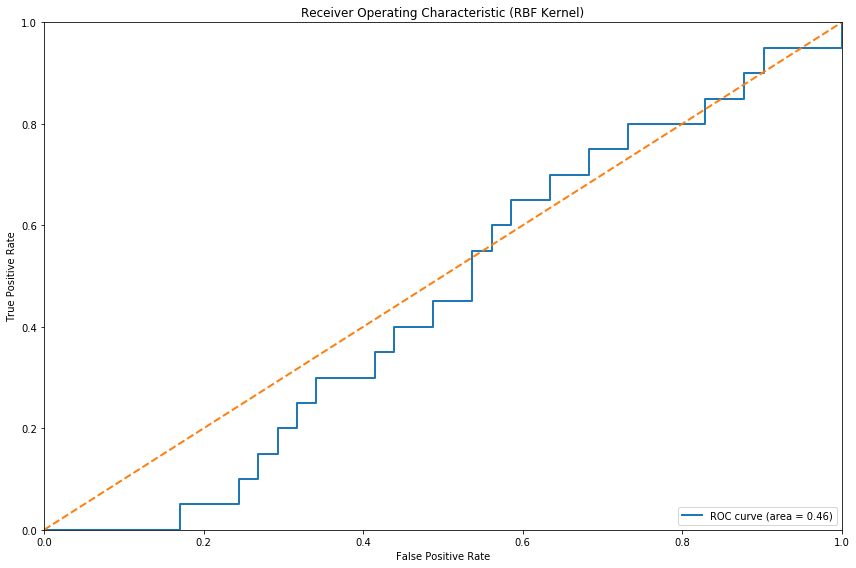

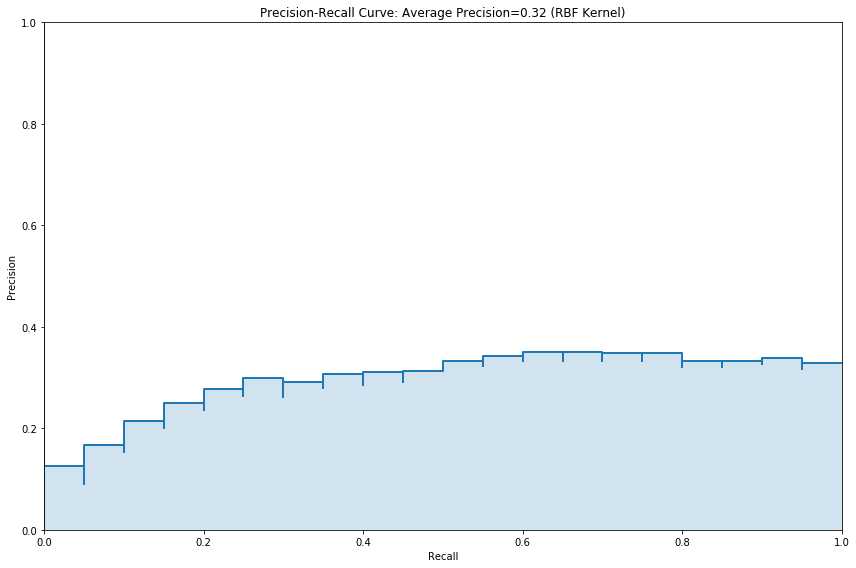

In [26]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import time

start = time.time()

def get_tuned_classifier(df_train_X, df_train_y):
    scoring = {'F1 Score': 'f1'}
    param_grid = [
        {
            'C': np.logspace(-5, 21, num=5, base=2), # 21
            'gamma': np.logspace(-15, 19, num=5, base=2), # 19
            'kernel': ['rbf', 'sigmoid']
        },
        {
            'C': np.logspace(-5, 15, num=21, base=2), # 21,
            'degree': np.arange(2, 17),
            'kernel': ['poly']
        },
        {
            'C': np.logspace(-5, 7, num=21, base=2), # 21
            'kernel': ['linear']
        }
    ]
    gs = GridSearchCV(SVC(probability=True, random_state=RANDOM_STATE),
                      param_grid=param_grid,
                      scoring=scoring,
                      cv=10,
                      refit='F1 Score',
                      n_jobs=4,
                      verbose=50)
    gs.fit(df_train_X, df_train_y)
    best_classifier = gs.best_estimator_
    return best_classifier, gs

classifier_tuned, grid_search_result = get_tuned_classifier(df_train_X, df_train_y)
print_classifier_results(classifier_tuned, df_eval_X, df_eval_y)

end = time.time()
print(end - start)

In [27]:
f1_tuned = cross_val_score(grid_search_result.best_estimator_, df_eval_X, df_eval_y, cv=40, scoring='f1')
f1_baseline_true = cross_val_score(classifier_baseline_true, df_eval_X, df_eval_y, cv=40, scoring='f1')
f1_baseline_false = cross_val_score(classifier_baseline_false, df_eval_X, df_eval_y, cv=40, scoring='f1')

/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 20 members, which is too few. The minimum number of members in any class cannot be less than n_splits=40.
  % (min_groups, self.n_splits)), Warning)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-

In [28]:
from scipy.stats import ttest_rel

In [29]:
ttest_rel(f1_tuned, f1_baseline_false)

Ttest_relResult(statistic=3.0752095583318066, pvalue=0.0038324733222408775)

In [30]:
ttest_rel(f1_tuned, f1_baseline_true)

Ttest_relResult(statistic=-2.5047558178706613, pvalue=0.016541908671268413)

In [31]:
f1_tuned = cross_val_score(grid_search_result.best_estimator_, df_eval_X, df_eval_y, cv=21, scoring='f1')
f1_baseline_true = cross_val_score(classifier_baseline_true, df_eval_X, df_eval_y, cv=21, scoring='f1')
f1_baseline_false = cross_val_score(classifier_baseline_false, df_eval_X, df_eval_y, cv=21, scoring='f1')

/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 20 members, which is too few. The minimum number of members in any class cannot be less than n_splits=21.
  % (min_groups, self.n_splits)), Warning)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/jet/var/python/lib/python3.6/site-

In [32]:
ttest_rel(f1_tuned, f1_baseline_false)

Ttest_relResult(statistic=3.0276503540974917, pvalue=0.0066484765440352938)

In [33]:
ttest_rel(f1_tuned, f1_baseline_true)

Ttest_relResult(statistic=-2.4866053379799196, pvalue=0.021849044423774604)